# Methods

We consider two general strategies for determining a **semantic similarity threshold**.

1. **Manual calibration**  
   Human annotators read texts sampled across a range of cosine-similarity values and label whether each text is semantically related to the target concept. The threshold is then chosen at the lowest cosine value above which agreement on “semantically related” is consistently high.

2. **Automated calibration**  
   An algorithm estimates, for each embedding model, the cosine-similarity threshold that best separates semantically related from unrelated texts.

## Proposed automated method

We introduce an unsupervised procedure that identifies the point at which adding lower-scoring items degrades cluster quality:

- Let texts be ranked in descending order by cosine similarity to a reference (query, prototype, or centroid).
- Construct two clusters, \(A\) and \(B\), where \(A\) is incrementally populated by appending the next block of highest-ranked texts and \(B\) contains the remaining items.
- After each increment, compute the **silhouette coefficient** or **avg_intra_cosine** over \(\{A,B\}\).
- The **semantic threshold** is selected at (or just before) the point where the silhouette begins a sustained decline, indicating that \(A\) is starting to absorb semantically heterogeneous texts.

This procedure yields a model-specific cutoff that adapts to differences in embedding space geometry and cosine-score dispersion.



In [ ]:
from dotenv import load_dotenv
import os
from google import genai
import openai
from openai import OpenAI
from mistralai import Mistral
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
import voyageai
from sklearn.metrics.pairwise import cosine_similarity


import matplotlib.pyplot as plt
from sklearn.metrics import (
    calinski_harabasz_score,
)

from scipy.ndimage import uniform_filter1d

# Import for annotation interface
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import ipywidgets as w
from IPython.display import display
import seaborn as sns


In [3]:
parquet_path = r"..\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_obdobie_8.parquet"
df = pd.read_parquet(parquet_path, engine="fastparquet")

In [4]:
load_dotenv(r"..\keys.env")

True

In [5]:
openai_api_key = os.getenv("OPENAI_API_KEY")
google_api_key = os.getenv("GOOGLE_API_KEY")
mistral_api_key = os.getenv("MISTRAL_API_KEY")
VOYAGE_API_KEY = os.getenv("VOYAGE_API_KEY")


# Initialize the clients
client = OpenAI(api_key=openai_api_key)
google_model = genai.Client(api_key=google_api_key)
mistral_client= Mistral(api_key=mistral_api_key)
voyageai.Client(api_key="VOYAGE_API_KEY")

##### **Corpus Selection**

I selected these textual corpora for their **boundary-like** nature: they center on highly polarized topics that seldom appear in other types of parliamentary interventions. Moreover, for many of these topics, an MP’s stance is readily inferable from party affiliation, which facilitates downstream validation of stance-sensitive analyses.
 

In [6]:
anti_vaccine_queries = [
    "Očkovanie nesmie byt v ziadnom pripade povinne.",
    "Nikto nevie ake bude mat ockovanie nasledky do buducnosti. Vakcina nebola vobec riadne odskusana. Je to neodskusana latka",
    "Očkovanie je hlavne velky biznis. My sa tu ockujeme neznamou latkou a farmaceuticke firmy budu mat obrovske zisky",
    "To ockovanie vobec nefunguje. Ak sa zaockujete stale mozete dostat Covid"
]

pro_russian_queries = [
    "Nerobme z Ruska nášho nepriatela Rusko nie je náš nepriateľ.",
    "Rusko vyprokovalo rozširovanie do NATO. Rusko nikdy nedovolí,  aby Ukrajina bola v NATO",
    "Dodavanim zbrani ten konflit len predlžujme.Ak budeme posielat zbrane tak ten konflikt predlžime a viac ľudí bude umierať",
    "Všetci len strašite Ruskom, že Rusko je zle. Ale čo Irak a Juhoslavia čo bombardovali Američania a USA. Prečo ste boli vtedy ticho? ",
    "Sankciami poškudzujeme len seba. Rusko sankciami vobec netrpi. Bez ruskeho plynu to pomrzneme "
]

anti_gender_narrative = [
    "Gender  a rodová ideologia nás ohrozuje",
    "My tu nechceme mať 72 pohlaví",
    "Pohlavie je sociálny konštrukt podľa gender a rodovej ideologie ",
    "Rodovú a gender ideológia  tvrdí, že nezáleží na vrodenom biologickom pohlaví.",
    "Rodová a gender ideológia  tvrdí, každý má mať možnosť vybrať si, ci je mužom alebo ženou, alebo niečo medzi tým",
    "Presadzovať rodovú a gender spolu s LGBTI na školach by malo byt zakazané"
]

#anti_smer = ["SMER je ovladany oligarchami", "SMER je mafia, ktorá okrada Slovensko", "Financne skupiny okradaju Slovennsko  a to len vďaka SMERU", "Mafia je na policii, Mafia je na sudoch. SMER nechal vyrast mafiu", "Korupcia a klientelizmus je najvačši problem na Slovensku, a to hlavne vdaka SMER-SD", 
                                 #"Zlodejstva SMERU su najvacsim problemom Slovenska"]

In [7]:
narratives_dict = {
    "vaccine_similarity": anti_vaccine_queries,
    "russian_similarity": pro_russian_queries,
    "gender_similarity": anti_gender_narrative,
    #"smer_similarity":anti_smer,
}

In [8]:
def get_embedding(input_text, model_name):
    """
    Unified embedding function for all supported models.
    Args:
        input_text (str): The text to embed.
        model_name (str): One of 'openai_large', 'openai_small', 'gemini', 'mistral', 'voyage'.
    Returns:
        np.ndarray: Embedding vector.
    """
    if model_name == 'openai_large':
        response = openai.embeddings.create(
            input=[input_text],
            model="text-embedding-3-large"
        )
        return np.array(response.data[0].embedding)
    elif model_name == 'openai_small':
        response = openai.embeddings.create(
            input=[input_text],
            model="text-embedding-3-small"
        )
        return np.array(response.data[0].embedding)
    elif model_name == 'gemini':
        result = google_model.models.embed_content(
            model="gemini-embedding-exp-03-07",
            contents=input_text
        )
        return np.array(result.embeddings[0].values)
    elif model_name == 'mistral':
        response = mistral_client.embeddings.create(model="mistral-embed", inputs=[input_text])
        return np.array(response.data[0].embedding)
    elif model_name == 'voyage':
        vo = voyageai.Client()
        try:
            result = vo.embed(
                [input_text],
                model="voyage-3-large",
                input_type="document",
                output_dimension=2048
            )
            return np.array(result.embeddings[0])
        except voyageai.error.RateLimitError:
            print("Rate limit hit, waiting before retrying...")
            time.sleep(60)
            result = vo.embed(
                [input_text],
                model="voyage-3-large",
                input_type="document",
                output_dimension=2048
            )
            return np.array(result.embeddings[0])
    else:
        raise ValueError(f"Unknown model_name: {model_name}")


def get_combined_narrative_embedding_model(narrative_list, model_name):
    """
    Returns the combined embedding for a narrative list using the specified model.
    Args:
        narrative_list (list of str): List of narrative texts.
        model_name (str): Model identifier for get_embedding.
    Returns:
        np.ndarray: Embedding vector for the combined narrative.
    """
    narrative_list = [str(item) for item in narrative_list]
    combined_narrative = " ".join(narrative_list)
    return get_embedding(combined_narrative, model_name)

def calculate_similarity(df, embedding_col, ref_embedding, similarity_col):
    """
    Calculates cosine similarity between each embedding in 'df[embedding_col]'
    and 'ref_embedding', storing the result in 'similarity_col'.
    """
    df[similarity_col] = df[embedding_col].apply(
        lambda x: cosine_similarity(
            np.array(x).reshape(1, -1),
            ref_embedding.reshape(1, -1)
        )[0][0]
    )
    return df


def compute_multiple_similarities(
    df,
    embedding_col,
    narratives_dict):
    """
    For each entry in 'narratives_dict' (a dict of {similarity_col: text_list}),
    compute a combined embedding and then calculate cosine similarities
    against df[embedding_col].

    Args:
        df (pd.DataFrame): DataFrame containing existing embeddings in 'embedding_col'.
        embedding_col (str): Column name where each row's embedding (list/array) is stored.
        narratives_dict (dict): A dict where key is the new similarity column name,
            and value is a list of texts that should be combined and embedded.
        model (str): Name of the model to use for embedding.

    Returns:
        pd.DataFrame: The updated DataFrame with new similarity columns appended.
    """
    for similarity_col, text_list in narratives_dict.items():
        # 2A) Get combined embedding for the entire list of texts
        ref_emb = get_combined_narrative_embedding(text_list)
        # 2B) Calculate similarities for the entire DataFrame
        df = calculate_similarity(df, embedding_col, ref_emb, similarity_col)
    return df

In [9]:
# Define the models and their embedding columns
embedding_models = {
    'openAI_embedding_3076': 'openAI_embedding_3076',
    'mistral_embedings': 'mistral_embedings',
    'voyage-3-large_embeddings': 'voyage-3-large_embeddings',
    'gemini-embedding-exp-03-07': 'gemini-embedding-exp-03-07',
    'openAI_embedding_small': 'openAI_embedding_small',
}


In [10]:
# Mapping from embedding column to model_name for get_embedding
embedding_model_map = {
    'openAI_embedding_3076': 'openai_large',
    'openAI_embedding_small': 'openai_small',
    'gemini-embedding-exp-03-07': 'gemini',
    'mistral_embedings': 'mistral',
    'voyage-3-large_embeddings': 'voyage',
}

for emb_col, model_name in embedding_model_map.items():
    for narrative_name, narrative_list in narratives_dict.items():
        narrative_emb = get_combined_narrative_embedding_model(narrative_list, model_name)
        sim_col = f"{emb_col}_{narrative_name}_cosine_score"
        if narrative_emb is not None:
            df[sim_col] = df[emb_col].apply(
                lambda x: cosine_similarity(np.array(x).reshape(1, -1), narrative_emb.reshape(1, -1))[0][0]
                if x is not None else np.nan
            )

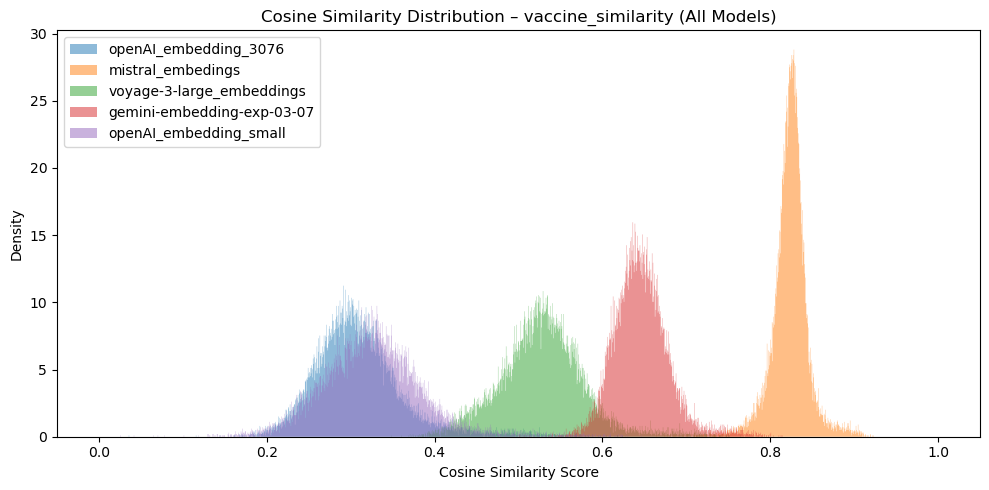

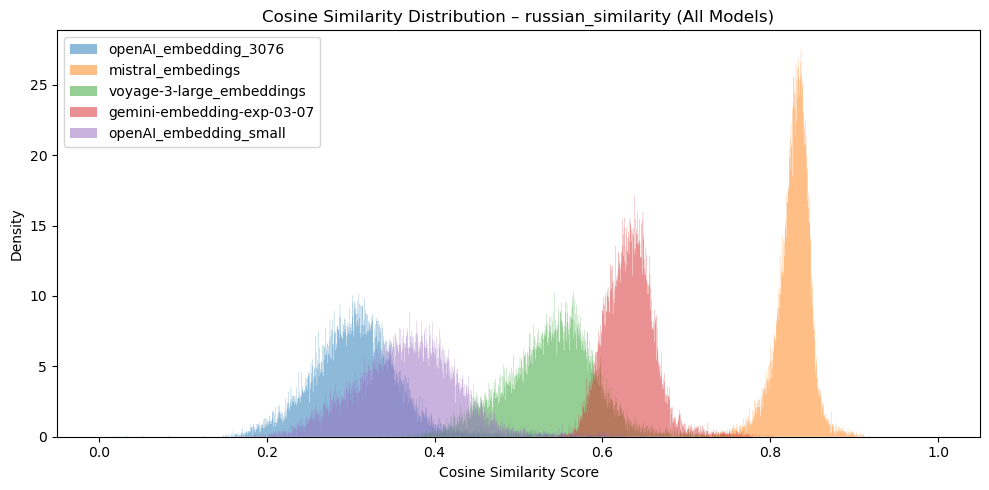

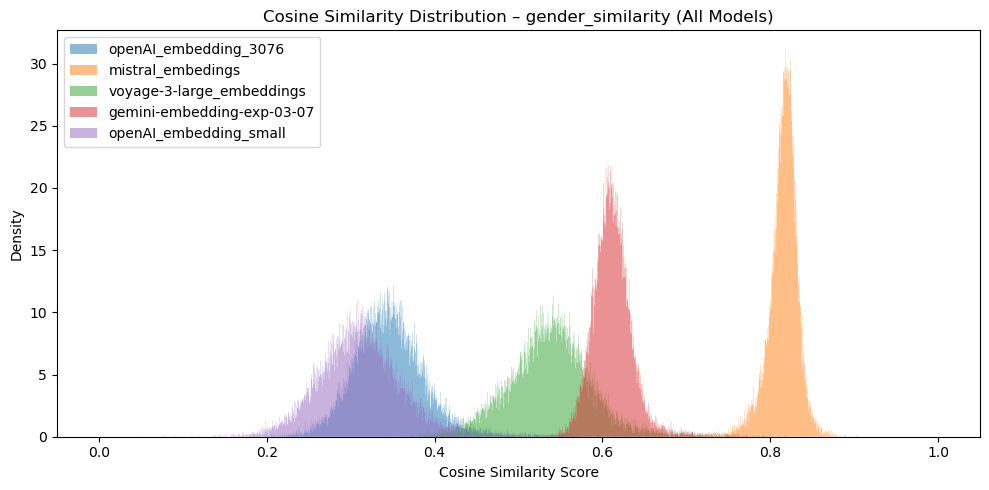

In [11]:
# Overlayed distributions for each narrative: all models on one plot per narrative
bin_width = 0.0005
bins = np.arange(0, 1 + bin_width, bin_width)

for narrative_name in narratives_dict.keys():
    plt.figure(figsize=(10, 5))
    for model, emb_col in embedding_models.items():
        sim_col = f"{emb_col}_{narrative_name}_cosine_score"
        if sim_col in df.columns:
            sims = df[sim_col].dropna().values
            plt.hist(sims, bins=bins, alpha=0.5, label=model, density=True, histtype='stepfilled')
    plt.title(f"Cosine Similarity Distribution – {narrative_name} (All Models)")
    plt.xlabel("Cosine Similarity Score")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(rf"..\graphs\cosine_similarity_distribution_{narrative_name}.png")
    plt.show()

In [17]:
def results_to_df(threshold_results: dict) -> pd.DataFrame:
    """
    Convert nested threshold results to simple DataFrame for Slovak parliamentary analysis.
    
    Args:
        threshold_results: Results from collect_thresholds_all()
        
    Returns:
        pd.DataFrame: Clean DataFrame with embedding model, narrative, and threshold info
    """
    rows = []
    
    for embedding_model, narratives in threshold_results.items():
        for narrative, result in narratives.items():
            rows.append({
                'embedding_model': embedding_model,
                'narrative': narrative,
                'threshold': result.get('threshold', np.nan),
                'method': result.get('method', 'unknown'),
                'metric': result.get('metric', 'unknown'),
                'has_threshold': not np.isnan(result.get('threshold', np.nan))
            })
    
    return pd.DataFrame(rows)



In [12]:
plt.style.use("seaborn-v0_8-paper")

# ----------------- elbow pickers -----------------
def elbow_index_pwlf(y: np.ndarray) -> int | None:
    """
    Two-segment piecewise linear fit; return break index in original y.
    Requires `pwlf` only when used.
    """
    import numpy as np
    mask = np.isfinite(y)
    if mask.sum() < 4:
        return None
    # lazy import to avoid hard dependency when using 'elbow'
    try:
        import pwlf
    except ImportError as e:
        raise ImportError("PWLF requested but 'pwlf' is not installed. "
                          "pip install pwlf") from e
    x = np.arange(len(y))
    model = pwlf.PiecewiseLinFit(x[mask], y[mask].astype(float))
    brk_x = model.fit(2)[1]
    brk_i = int(round(brk_x))
    finite_idx = np.where(mask)[0]
    brk_i = min(max(brk_i, 0), len(finite_idx) - 1)
    return finite_idx[brk_i]

def elbow_index_curvature(y: np.ndarray) -> int | None:
    """
    Simple elbow: index with most negative second difference (largest curvature).
    """
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(y)
    if mask.sum() < 4:
        return None
    yy = y[mask]
    d1 = np.diff(yy)
    if len(d1) < 2:
        return None
    d2 = np.diff(d1)
    # map back: d2 corresponds to original indices 1..len-2 within the masked array
    rel = np.where(mask)[0][1:-1]
    i_local = int(np.argmin(d2))
    return int(rel[i_local])

def compute_avg_intra_cluster_cosine(embeddings: np.ndarray, positive_indices: np.ndarray) -> float:
    """
    Compute average pairwise cosine similarity within positive cluster only.
    
    Args:
        embeddings: All embeddings (n_samples, n_features)
        positive_indices: Indices of positive samples
        
    Returns:
        Average intra-cluster cosine similarity for positives
    """
    if len(positive_indices) < 2:
        return np.nan
    
    # Get positive embeddings only
    pos_emb = embeddings[positive_indices]
    
    # Compute pairwise cosine similarities
    from sklearn.metrics.pairwise import cosine_similarity
    cos_sim_matrix = cosine_similarity(pos_emb)
    
    # Get upper triangle (excluding diagonal) for unique pairs
    n = len(pos_emb)
    upper_triangle = np.triu(cos_sim_matrix, k=1)
    
    # Calculate average of non-zero elements (upper triangle)
    n_pairs = n * (n - 1) // 2
    if n_pairs == 0:
        return np.nan
    
    avg_similarity = np.sum(upper_triangle) / n_pairs
    return avg_similarity

# ----------------- core (one score/embedding) -----------------
def threshold_for_one(
    df: pd.DataFrame,
    embed_col: str,
    score_col: str,
    step_size: int = 50,
    max_dataset_fraction: float = 0.1,
    max_rows: int = 6000,
    neg_factor: float = 2.0,            # cap negatives to <= neg_factor * positives
    smooth: int = 3,
    method: str = "pwlf",               # "pwlf" or "elbow"
    metric: str = "calinski_harabasz",  # NEW: "calinski_harabasz" or "avg_intra_cosine"
    random_state: int = 0,
    plot: bool = False,
):
    """
    Progressive batching by descending `score_col`; compute clustering metric per batch;
    choose knee by PWLF (default) or curvature-based elbow.
    
    Args:
        metric: Either "calinski_harabasz" (CH score) or "avg_intra_cosine" (average cosine similarity within positives only)

    Returns: dict with 'threshold', 'method', 'metric', 'elbow_idx', 'curve', 'batch_indices'.
    """
    rng = np.random.default_rng(random_state)

    # fixed subsample for speed/repro
    if len(df) > max_rows:
        take = rng.choice(len(df), size=max_rows, replace=False)
        df_s = df.iloc[take].reset_index(drop=True)
    else:
        df_s = df.reset_index(drop=True)

    emb = np.vstack(df_s[embed_col].values).astype("float32")  # assume already unit-normalized
    sims = df_s[score_col].to_numpy()
    order = np.argsort(-sims)  # high → low

    max_steps = max(step_size, int(max_dataset_fraction * len(df_s)))
    metric_curve, thresholds, batch_indices = [], [], []
    selected = []

    for k_start in range(0, min(max_steps, len(df_s)), step_size):
        batch_idx = order[k_start:k_start + step_size]
        if len(batch_idx) == 0:
            break
        selected.extend(batch_idx)

        labels = np.zeros(len(df_s), dtype=int)
        labels[selected] = 1

        pos_idx = np.where(labels == 1)[0]
        neg_idx = np.where(labels == 0)[0]

        # Compute the selected metric
        if metric == "calinski_harabasz":
            # Original CH score implementation
            if len(pos_idx) >= 2 and len(neg_idx) >= 2:
                # optional negative downsampling improves CH stability
                max_neg = int(min(len(neg_idx), neg_factor * len(pos_idx)))
                if max_neg < len(neg_idx):
                    neg_keep = rng.choice(neg_idx, size=max_neg, replace=False)
                    keep = np.concatenate([pos_idx, neg_keep])
                    metric_val = calinski_harabasz_score(emb[keep], labels[keep])
                else:
                    metric_val = calinski_harabasz_score(emb, labels)
            else:
                metric_val = np.nan
                
        elif metric == "avg_intra_cosine":
            # NEW: Average intra-cluster cosine similarity for positives only
            if len(pos_idx) >= 2:
                metric_val = compute_avg_intra_cluster_cosine(emb, pos_idx)
            else:
                metric_val = np.nan
        else:
            raise ValueError(f"Unknown metric: {metric}. Use 'calinski_harabasz' or 'avg_intra_cosine'")

        metric_curve.append(metric_val)
        thresholds.append(sims[selected[-1]])           # lowest score currently inside positives
        batch_indices.append(k_start // step_size)

    if len(metric_curve) == 0:
        return {"threshold": np.nan, "method": method, "metric": metric, "elbow_idx": None,
                "curve": [], "batch_indices": []}

    # smooth for robustness
    metric_sm = uniform_filter1d(np.array(metric_curve, dtype=float), size=smooth, mode="nearest")

    # pick elbow
    if method == "pwlf":
        elbow_idx = elbow_index_pwlf(metric_sm)
    else:
        elbow_idx = elbow_index_curvature(metric_sm)

    if elbow_idx is None:
        τ = np.nan
    else:
        elbow_idx = min(elbow_idx, len(thresholds) - 1)
        τ = float(thresholds[elbow_idx])

    # optional plot
    if plot and len(batch_indices) > 0:
        bi = np.array(batch_indices)
        plt.figure(figsize=(7, 4))
        plt.plot(bi, metric_sm, "o-", label=f"{metric} (smoothed)")
        if elbow_idx is not None:
            plt.axvline(bi[min(elbow_idx, len(bi)-1)], color="k", ls="--", label=f"τ={τ:.3f}")
        
        # Update plot labels based on metric
        metric_label = "Calinski–Harabasz ↑" if metric == "calinski_harabasz" else "Avg Intra-Cluster Cosine ↑"
        plt.title(f"{metric.replace('_', ' ').title()} curve – {score_col} [{method}]")
        plt.xlabel(f"Batch index ({step_size} speeches each)")
        plt.ylabel(metric_label)
        plt.legend()
        plt.tight_layout()
        plt.savefig(rf"..\graphs\threshold_curve_{embed_col}_{score_col}_{metric}_{method}.png")
        plt.show()

    return {"threshold": τ, "method": method, "metric": metric, "elbow_idx": elbow_idx,
            "curve": metric_curve, "batch_indices": batch_indices}

# ----------------- orchestrator (all embeddings × narratives) -----------------
def collect_thresholds_all(
    df: pd.DataFrame,
    embedding_models: dict,   # {model_alias: embed_col_name}
    narratives: dict | list,  # iterable of narrative keys
    step_size: int = 50,
    max_dataset_fraction: float = 0.1,
    max_rows: int = 6000,
    neg_factor: float = 2.0,
    smooth: int = 3,
    method: str = "pwlf",     # "pwlf" or "elbow"
    metric: str = "calinski_harabasz",  # NEW: "calinski_harabasz" or "avg_intra_cosine"
    random_state: int = 0,
    plot_each: bool = False,
):
    """
    Collect thresholds for all embedding models and narratives using specified metric.
    
    Args:
        metric: Either "calinski_harabasz" or "avg_intra_cosine"
    
    Returns nested dict:
      result[model][narr] = {
         "threshold": τ,
         "method": "pwlf"|"elbow",
         "metric": "calinski_harabasz"|"avg_intra_cosine",
         "elbow_idx": i,
         "curve": [...],
         "batch_indices": [...]
      }
    """
    result = {}
    
    print(f"🏛️ SLOVAK PARLIAMENT THRESHOLD ANALYSIS")
    print(f"Using metric: {metric.replace('_', ' ').title()}")
    print(f"Method: {method.upper()}")
    print("=" * 60)
    
    for model, emb_col in embedding_models.items():
        result[model] = {}
        print(f"\n📊 Processing model: {model}")
        
        for narr in narratives:
            score_col = f"{emb_col}_{narr}_cosine_score"
            if score_col not in df.columns:
                print(f"  ⚠️ Skipping {narr}: column {score_col} not found")
                continue
                
            print(f"  🎯 Analyzing narrative: {narr.replace('_similarity', '')}")
            
            r = threshold_for_one(
                df=df,
                embed_col=emb_col,
                score_col=score_col,
                step_size=step_size,
                max_dataset_fraction=max_dataset_fraction,
                max_rows=max_rows,
                neg_factor=neg_factor,
                smooth=smooth,
                method=method,
                metric=metric,  # Pass the metric parameter
                random_state=random_state,
                plot=plot_each,
            )
            
            result[model][narr] = {
                "threshold": r["threshold"],
                "method": r["method"],
                "metric": r["metric"],
                "elbow_idx": r["elbow_idx"],
                "curve": r["curve"],
                "batch_indices": r["batch_indices"],
            }
            
            # Print threshold result
            if not np.isnan(r["threshold"]):
                print(f"    ✅ Threshold found: {r['threshold']:.4f}")
            else:
                print(f"    ⚠️ No threshold found")
    
    return result

def compare_metrics_for_narrative(
    df: pd.DataFrame,
    embedding_models: dict,
    narrative: str,
    step_size: int = 50,
    method: str = "pwlf",
    plot: bool = True
):
    """
    Compare Calinski-Harabasz vs Average Intra-Cluster Cosine for a specific narrative
    across all embedding models for Slovak parliamentary speeches.
    """
    print(f"🏛️ METRIC COMPARISON: {narrative.replace('_similarity', '').title()} Narrative")
    print("=" * 70)
    
    results = {}
    
    for metric in ["calinski_harabasz", "avg_intra_cosine"]:
        print(f"\n📊 Running analysis with {metric.replace('_', ' ').title()}...")
        
        results[metric] = collect_thresholds_all(
            df=df,
            embedding_models=embedding_models,
            narratives=[narrative],
            step_size=step_size,
            method=method,
            metric=metric,
            plot_each=plot
        )
    
    # Compare results
    print(f"\n🔍 THRESHOLD COMPARISON for {narrative.replace('_similarity', '')}:")
    print("-" * 50)
    
    for model in embedding_models.keys():
        if narrative in results["calinski_harabasz"][model] and narrative in results["avg_intra_cosine"][model]:
            ch_thresh = results["calinski_harabasz"][model][narrative]["threshold"]
            cosine_thresh = results["avg_intra_cosine"][model][narrative]["threshold"]
            
            print(f"{model}:")
            print(f"  Calinski-Harabasz: {ch_thresh:.4f}" if not np.isnan(ch_thresh) else "  Calinski-Harabasz: No threshold found")
            print(f"  Avg Intra-Cosine:  {cosine_thresh:.4f}" if not np.isnan(cosine_thresh) else "  Avg Intra-Cosine: No threshold found")
            
            if not np.isnan(ch_thresh) and not np.isnan(cosine_thresh):
                diff = abs(ch_thresh - cosine_thresh)
                print(f"  Difference: {diff:.4f}")
            print()
    
    return results

**Evaluation Note.**  
I tested multiple combinations of `step_size` and algorithmic **method**. The configuration reported here appears to perform best. 


🏛️ SLOVAK PARLIAMENT THRESHOLD ANALYSIS
Using metric: Avg Intra Cosine
Method: PWLF

📊 Processing model: openAI_embedding_3076
  🎯 Analyzing narrative: vaccine


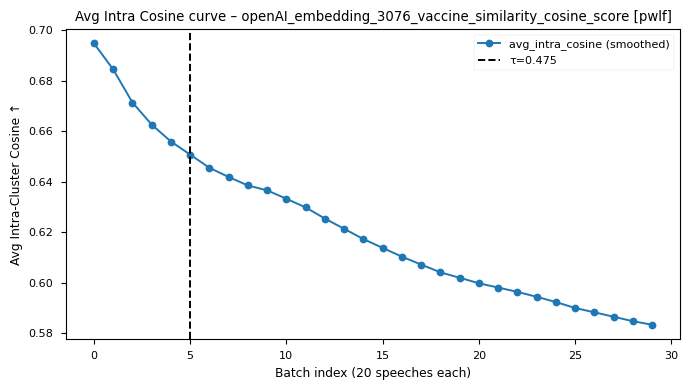

    ✅ Threshold found: 0.4753
  🎯 Analyzing narrative: russian


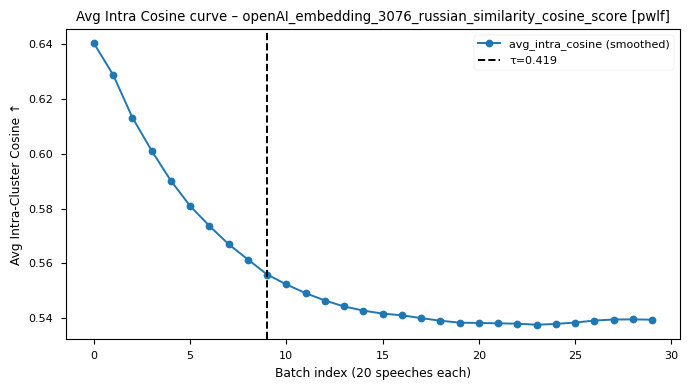

    ✅ Threshold found: 0.4189
  🎯 Analyzing narrative: gender


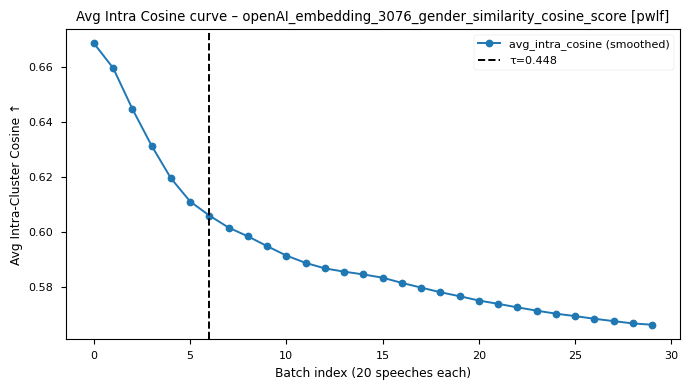

    ✅ Threshold found: 0.4477

📊 Processing model: mistral_embedings
  🎯 Analyzing narrative: vaccine


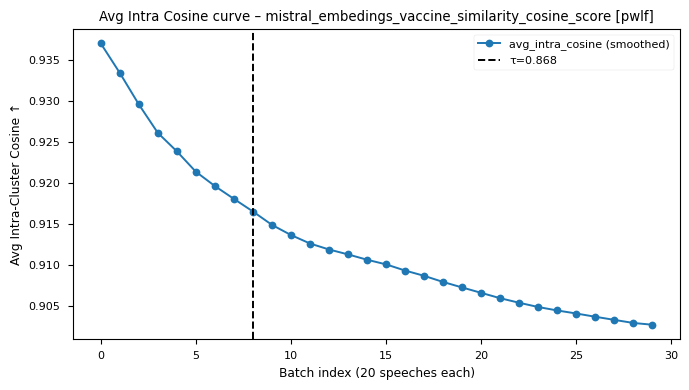

    ✅ Threshold found: 0.8677
  🎯 Analyzing narrative: russian


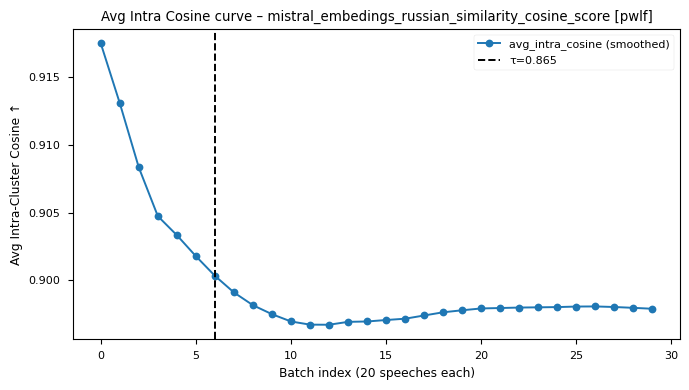

    ✅ Threshold found: 0.8651
  🎯 Analyzing narrative: gender


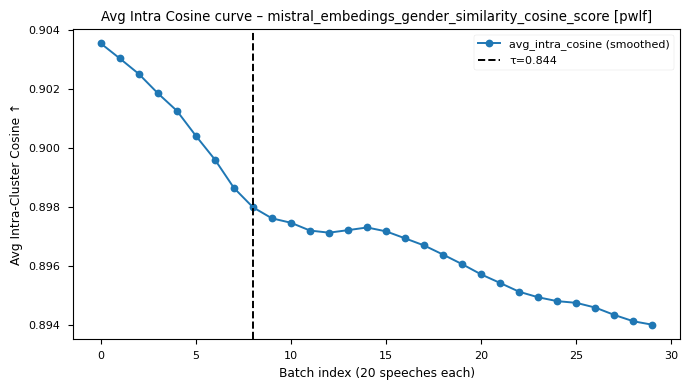

    ✅ Threshold found: 0.8438

📊 Processing model: voyage-3-large_embeddings
  🎯 Analyzing narrative: vaccine


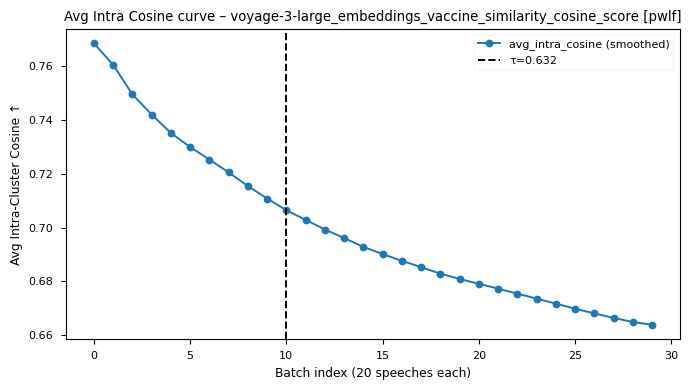

    ✅ Threshold found: 0.6316
  🎯 Analyzing narrative: russian


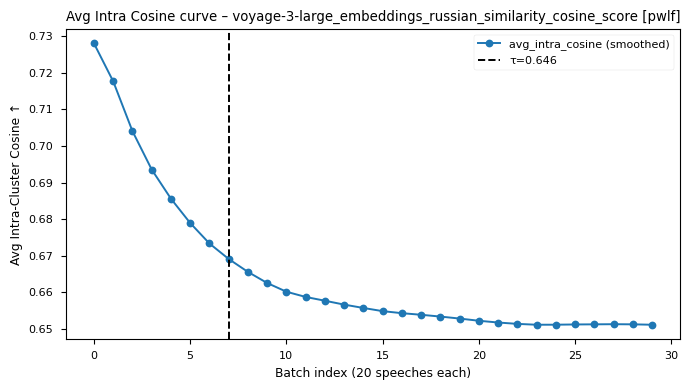

    ✅ Threshold found: 0.6459
  🎯 Analyzing narrative: gender


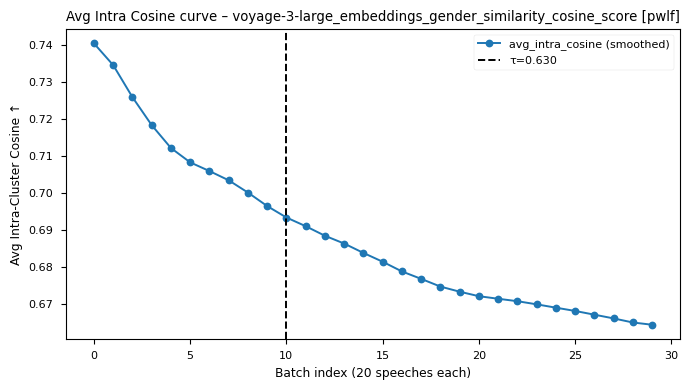

    ✅ Threshold found: 0.6304

📊 Processing model: gemini-embedding-exp-03-07
  🎯 Analyzing narrative: vaccine


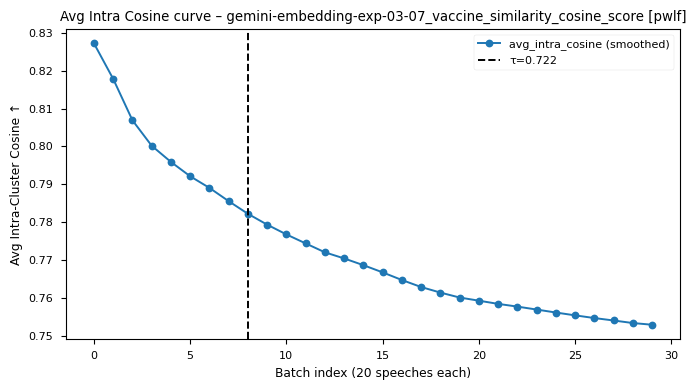

    ✅ Threshold found: 0.7216
  🎯 Analyzing narrative: russian


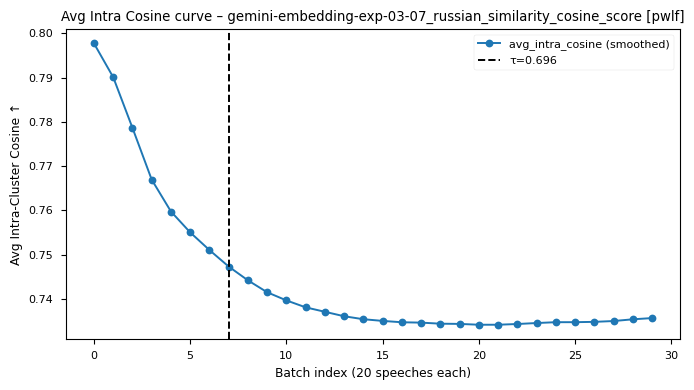

    ✅ Threshold found: 0.6964
  🎯 Analyzing narrative: gender


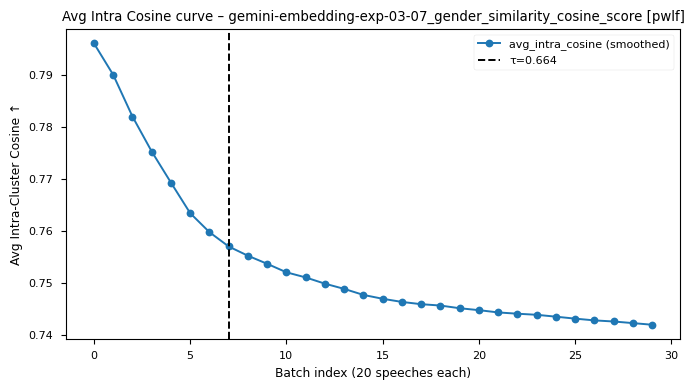

    ✅ Threshold found: 0.6639

📊 Processing model: openAI_embedding_small
  🎯 Analyzing narrative: vaccine


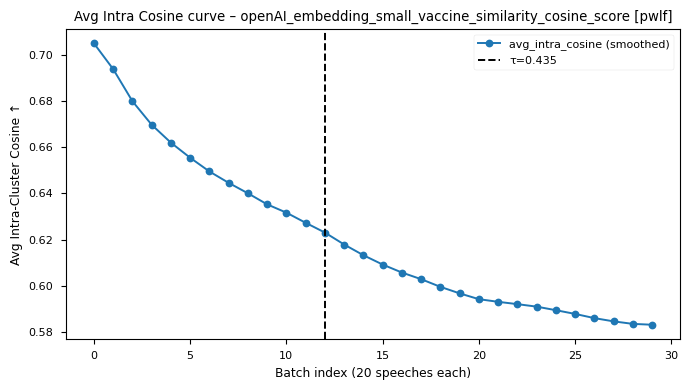

    ✅ Threshold found: 0.4352
  🎯 Analyzing narrative: russian


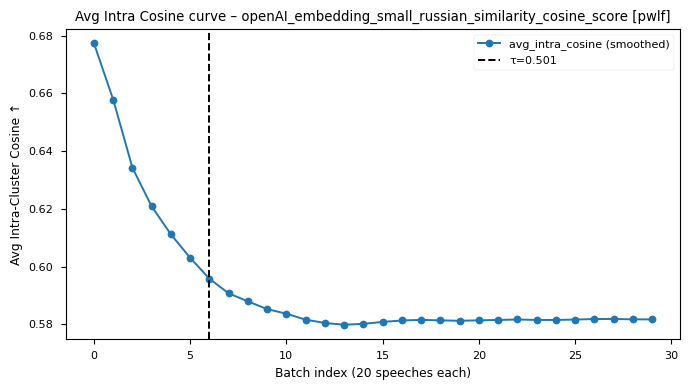

    ✅ Threshold found: 0.5007
  🎯 Analyzing narrative: gender


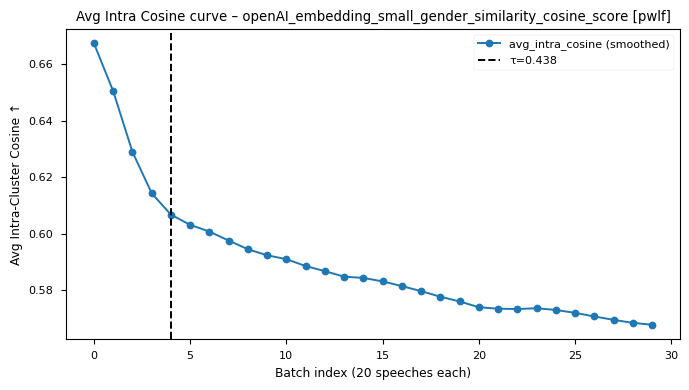

    ✅ Threshold found: 0.4383


In [13]:
# New cosine-based thresholds for Slovak parliamentary speeches
cosine_results_pwlf = collect_thresholds_all(
    df,
    embedding_models=embedding_models,
    narratives=narratives_dict,
    metric="avg_intra_cosine",
    step_size=20,  
    method="pwlf",
    plot_each=True
)


In [18]:
# Convert your cosine_results_pwlf to DataFrame
threshold_df = results_to_df(cosine_results_pwlf)
threshold_df.to_csv(r"..\data\slovak_parliament_thresholds_avg_intra_cosine_pwlf.csv", index=False)


In [20]:
def apply_narrative_thresholds(df: pd.DataFrame, threshold_results: dict, verbose: bool = True) -> pd.DataFrame:
    """
    Apply semantic thresholds to Slovak parliamentary speeches and create binary above-threshold columns.
    
    For Slovak parliamentary corpus (2010-2023) embedding effectiveness analysis.
    Creates binary columns indicating speeches above cosine similarity thresholds for each 
    embedding model-narrative combination tested on Slovak language.
    
    Args:
        df: Parliamentary transcription DataFrame with columns: 'prepis', 'klub', 'poslanec', 'obdobie'
        threshold_results: Results from collect_thresholds_all() containing PWLF/elbow thresholds
        verbose: Print detailed progress for Slovak parliamentary NLP research
        
    Returns:
        Original DataFrame with new binary threshold columns for narrative detection
    """
    if verbose:
        print("🏛️ SLOVAK PARLIAMENTARY EMBEDDING EFFECTIVENESS ANALYSIS")
        print("Adding semantic threshold columns to parliamentary transcriptions (2010-2023)")
        print("Testing: OpenAI, Mistral, Voyage, Gemini embeddings on Slovak language")
        print("=" * 75)
    
    binary_columns_created = []
    narrative_stats = {}
    
    # Process threshold results for Slovak parliamentary narrative detection
    for embedding_model, narratives in threshold_results.items():
        model_stats = {}
        
        if verbose:
            print(f"\n📊 Processing embedding model: {embedding_model}")
            
        for narrative, result in narratives.items():
            threshold = result.get("threshold", np.nan)
            method = result.get("method", "pwlf")
            metric = result.get("metric", "unknown")
            
            # Skip if no valid threshold found for this Slovak political narrative
            if np.isnan(threshold):
                if verbose:
                    narrative_clean = narrative.replace('_similarity', '').upper()
                    print(f"  ⚠️ No threshold for {narrative_clean} narrative")
                continue
            
            # Construct column names following Slovak parliamentary analysis convention
            score_col = f"{embedding_model}_{narrative}_cosine_score"
            binary_col = f"{embedding_model}_{narrative}_{method}_above_threshold"
            
            # Verify cosine score column exists for Slovak parliamentary speeches
            if score_col not in df.columns:
                if verbose:
                    print(f"  ⚠️ Missing cosine scores: {score_col}")
                continue
            
            # Create binary column: 1 if parliamentary speech above semantic threshold
            df[binary_col] = (df[score_col] >= threshold).astype(int)
            
            # Calculate statistics for Slovak parliamentary effectiveness analysis
            positive_speeches = df[binary_col].sum()
            total_speeches = len(df)
            percentage = (positive_speeches / total_speeches) * 100 if total_speeches > 0 else 0
            
            # Track for research documentation
            binary_columns_created.append(binary_col)
            model_stats[narrative] = {
                'threshold': threshold,
                'method': method,
                'metric': metric,
                'positive_speeches': positive_speeches,
                'percentage': percentage,
                'binary_column': binary_col
            }
            
            if verbose:
                narrative_clean = narrative.replace('_similarity', '').upper()
                print(f"  ✅ {narrative_clean}: threshold={threshold:.4f} ({method}), "
                      f"identified={positive_speeches} speeches ({percentage:.2f}%)")
        
        narrative_stats[embedding_model] = model_stats
    
    if verbose:
        print(f"\n🎯 SLOVAK PARLIAMENTARY THRESHOLD APPLICATION SUMMARY")
        print("=" * 75)
        print(f"Total binary threshold columns created: {len(binary_columns_created)}")
        
        # Summary by Slovak political narratives
        print(f"\n📈 POLITICAL NARRATIVE EFFECTIVENESS:")
        for narrative_key in ['vaccine_similarity', 'russian_similarity', 'gender_similarity']:
            narrative_name = narrative_key.replace('_similarity', '').title()
            total_identified = 0
            model_count = 0
            
            for model_data in narrative_stats.values():
                if narrative_key in model_data:
                    total_identified += model_data[narrative_key]['positive_speeches']
                    model_count += 1
            
            if model_count > 0:
                avg_per_model = total_identified / model_count
                print(f"  📊 {narrative_name} narrative: {total_identified} total speeches identified, "
                      f"avg {avg_per_model:.1f} per embedding model")
        
        # Embedding model effectiveness on Slovak language
        print(f"\n🤖 EMBEDDING MODEL EFFECTIVENESS (Slovak Language):")
        for model, data in narrative_stats.items():
            if data:
                total_speeches = sum(info['positive_speeches'] for info in data.values())
                avg_threshold = np.mean([info['threshold'] for info in data.values()])
                narratives_count = len(data)
                print(f"  {model}: {total_speeches} speeches identified across {narratives_count} narratives, "
                      f"avg_threshold={avg_threshold:.4f}")
        
        # Show club distribution for research context
        print(f"\n🏛️ POLITICAL CLUB ANALYSIS (Top clubs with narrative speeches):")
        for narrative_key in ['vaccine_similarity', 'russian_similarity', 'gender_similarity']:
            narrative_cols = [col for col in binary_columns_created if f'_{narrative_key}_' in col]
            if narrative_cols:
                # Use first available column for club analysis
                col = narrative_cols[0]
                narrative_speeches = df[df[col] == 1]
                if len(narrative_speeches) > 0:
                    top_clubs = narrative_speeches['klub'].value_counts().head(3)
                    narrative_clean = narrative_key.replace('_similarity', '').title()
                    print(f"  {narrative_clean}: {', '.join([f'{club}({count})' for club, count in top_clubs.items()])}")
        
        print(f"\n📋 NEW BINARY THRESHOLD COLUMNS:")
        print(f"Format: [embedding_model]_[narrative]_[method]_above_threshold")
        for i, col in enumerate(sorted(binary_columns_created)):
            print(f"  {i+1:2d}. {col}")
            
        print(f"\n💡 USAGE FOR SLOVAK PARLIAMENTARY RESEARCH:")
        print(f"  • Analyze narrative effectiveness: df[df['openAI_embedding_3076_vaccine_similarity_pwlf_above_threshold'] == 1]")
        print(f"  • Compare embedding models: compare columns with same narrative but different models")
        print(f"  • Study political club patterns: group by 'klub' column with threshold columns")
        print(f"  • Temporal analysis: use 'obdobie' column to track narrative evolution 2010-2023")
    
    return df

# Apply thresholds from your PWLF analysis to Slovak parliamentary corpus
df = apply_narrative_thresholds(df, cosine_results_pwlf, verbose=True)

🏛️ SLOVAK PARLIAMENTARY EMBEDDING EFFECTIVENESS ANALYSIS
Adding semantic threshold columns to parliamentary transcriptions (2010-2023)
Testing: OpenAI, Mistral, Voyage, Gemini embeddings on Slovak language

📊 Processing embedding model: openAI_embedding_3076
  ✅ VACCINE: threshold=0.4770 (pwlf), identified=365 speeches (1.83%)
  ✅ RUSSIAN: threshold=0.4187 (pwlf), identified=590 speeches (2.96%)
  ✅ GENDER: threshold=0.4490 (pwlf), identified=457 speeches (2.29%)

📊 Processing embedding model: mistral_embedings
  ✅ VACCINE: threshold=0.8677 (pwlf), identified=554 speeches (2.78%)
  ✅ RUSSIAN: threshold=0.8651 (pwlf), identified=422 speeches (2.12%)
  ✅ GENDER: threshold=0.8438 (pwlf), identified=631 speeches (3.17%)

📊 Processing embedding model: voyage-3-large_embeddings
  ✅ VACCINE: threshold=0.6258 (pwlf), identified=725 speeches (3.64%)
  ✅ RUSSIAN: threshold=0.6459 (pwlf), identified=473 speeches (2.37%)
  ✅ GENDER: threshold=0.6304 (pwlf), identified=744 speeches (3.73%)

📊 Proce


=== Creating chart for VACCINE_SIMILARITY ===


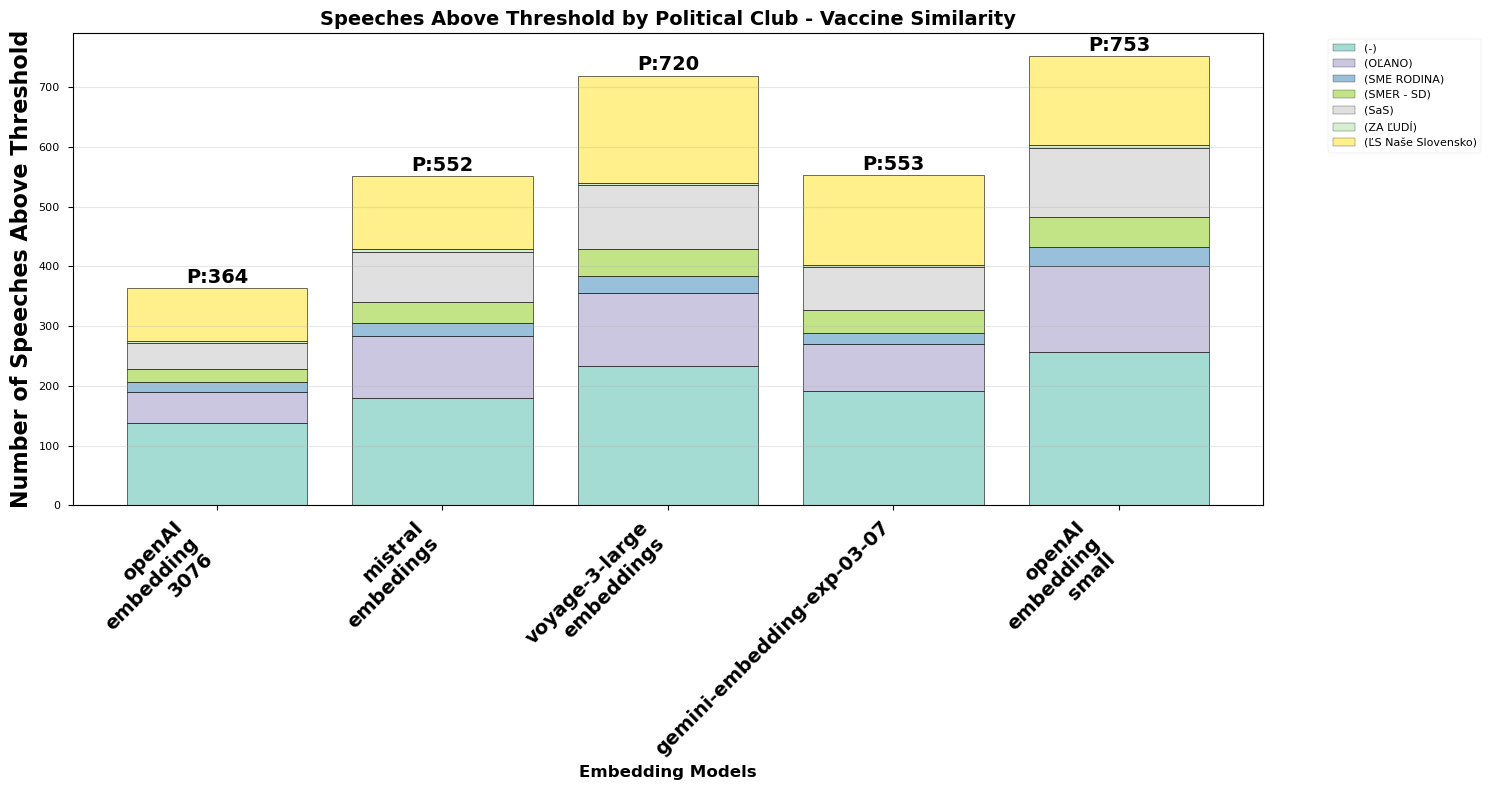


Summary for vaccine_similarity:
  openAI_embedding_3076: PWLF=364
  mistral_embedings: PWLF=552
  voyage-3-large_embeddings: PWLF=720
  gemini-embedding-exp-03-07: PWLF=553
  openAI_embedding_small: PWLF=753

=== Creating chart for RUSSIAN_SIMILARITY ===


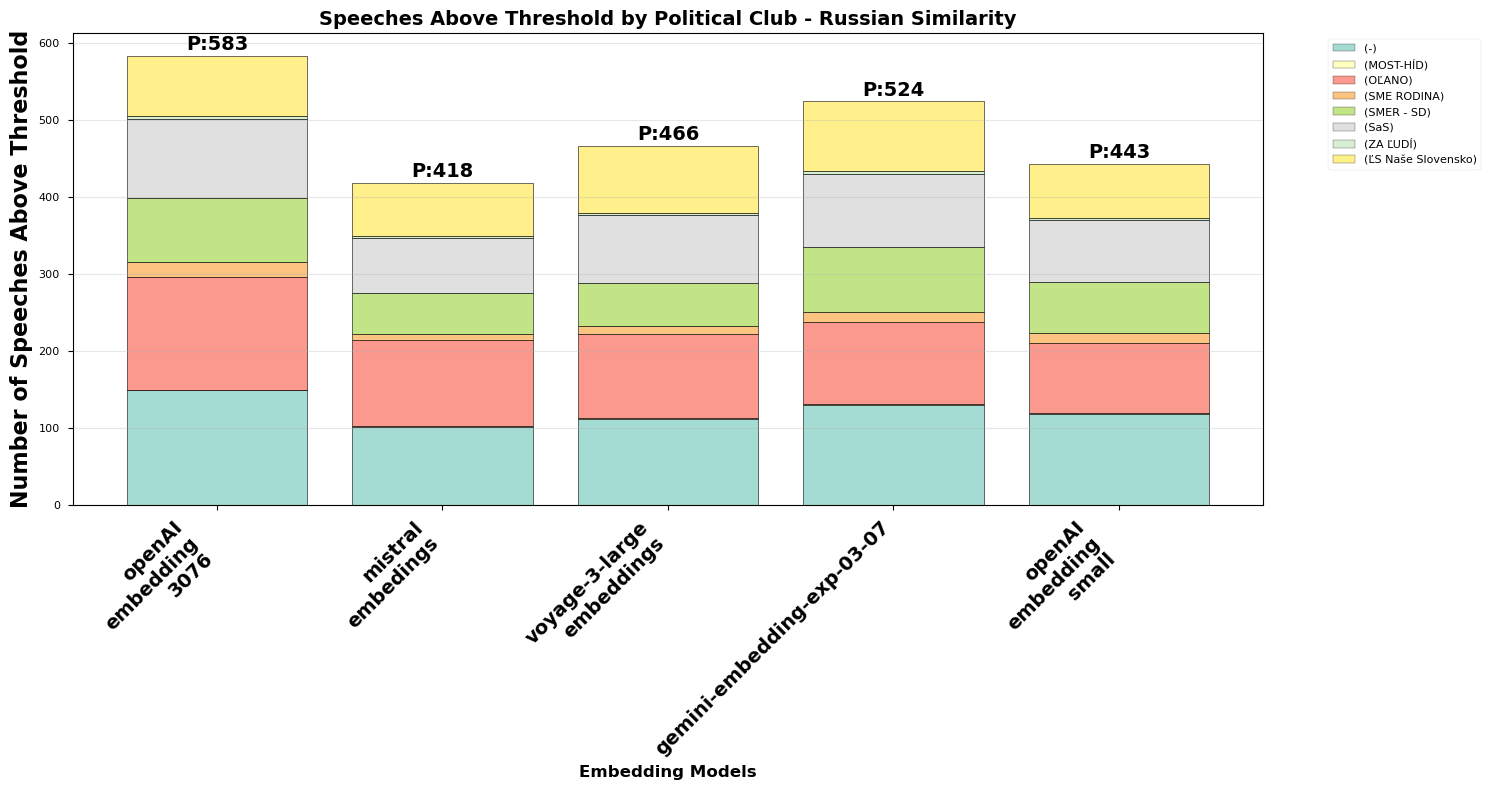


Summary for russian_similarity:
  openAI_embedding_3076: PWLF=583
  mistral_embedings: PWLF=418
  voyage-3-large_embeddings: PWLF=466
  gemini-embedding-exp-03-07: PWLF=524
  openAI_embedding_small: PWLF=443

=== Creating chart for GENDER_SIMILARITY ===


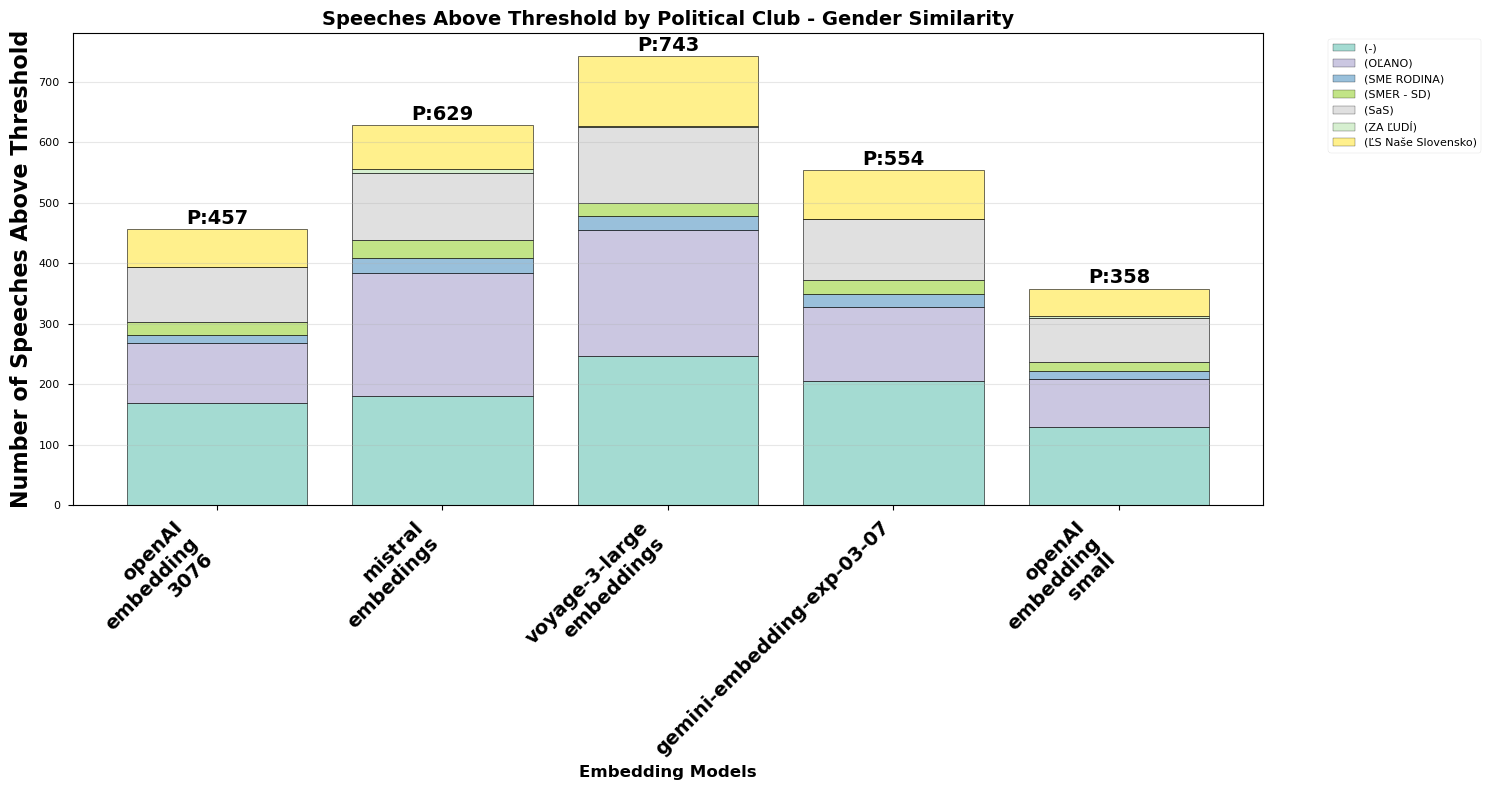


Summary for gender_similarity:
  openAI_embedding_3076: PWLF=457
  mistral_embedings: PWLF=629
  voyage-3-large_embeddings: PWLF=743
  gemini-embedding-exp-03-07: PWLF=554
  openAI_embedding_small: PWLF=358


In [21]:
# Create stacked bar charts by klub for each narrative

binary_cols = ['openAI_embedding_3076_vaccine_similarity_pwlf_above_threshold',
    'openAI_embedding_3076_russian_similarity_pwlf_above_threshold',
    'openAI_embedding_3076_gender_similarity_pwlf_above_threshold',
    'mistral_embedings_vaccine_similarity_pwlf_above_threshold',
    'mistral_embedings_russian_similarity_pwlf_above_threshold',
    'mistral_embedings_gender_similarity_pwlf_above_threshold',
    'voyage-3-large_embeddings_vaccine_similarity_pwlf_above_threshold',
    'voyage-3-large_embeddings_russian_similarity_pwlf_above_threshold',
    'voyage-3-large_embeddings_gender_similarity_pwlf_above_threshold',
    'gemini-embedding-exp-03-07_vaccine_similarity_pwlf_above_threshold',
    'gemini-embedding-exp-03-07_russian_similarity_pwlf_above_threshold',
    'gemini-embedding-exp-03-07_gender_similarity_pwlf_above_threshold',
    'openAI_embedding_small_vaccine_similarity_pwlf_above_threshold',
    'openAI_embedding_small_russian_similarity_pwlf_above_threshold',
    'openAI_embedding_small_gender_similarity_pwlf_above_threshold']

# Get unique embedding models (remove duplicates from column names)
unique_models = list(embedding_models.keys())

# For each narrative, create a plot
for narrative in ['vaccine_similarity', 'russian_similarity', 'gender_similarity']:
    print(f"\n=== Creating chart for {narrative.upper()} ===")
    
    # Collect data for this narrative
    pwlf_data = defaultdict(lambda: defaultdict(int))  # {model: {klub: count}}

    
    # Get all relevant columns for this narrative
    narrative_cols = [col for col in binary_cols if f'_{narrative}_' in col]
    
    if not narrative_cols:
        print(f"No threshold columns found for {narrative}")
        continue
    
    # Process each model for this narrative
    for model in unique_models:
        pwlf_col = f"{model}_{narrative}_pwlf_above_threshold"
        #elbow_col = f"{model}_{narrative}_elbow_above_threshold"
        
        # PWLF data
        if pwlf_col in df.columns:
            above_threshold = df[df[pwlf_col] == 1]
            if len(above_threshold) > 0:
                klub_counts = above_threshold['klub'].value_counts()
                for klub, count in klub_counts.items():
                    if count >= 1:  # Only include if count > 1
                        pwlf_data[model][klub] = count
    # Get all unique klubs across all models for this narrative
    all_klubs = set()
    for model_data in pwlf_data.values():
        all_klubs.update(model_data.keys())

    
    if not all_klubs:
        print(f"No data with count >= 1 found for {narrative}")
        continue
    
    all_klubs = sorted(list(all_klubs))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Set up positions
    x_pos = np.arange(len(unique_models))
    width = 0.8
    
    # Colors for different klubs
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_klubs)))
    
    # Create stacked bars for PWLF (main bars)
    bottom_pwlf = np.zeros(len(unique_models))
    for i, klub in enumerate(all_klubs):
        heights_pwlf = []
        for model in unique_models:
            count = pwlf_data[model].get(klub, 0)
            heights_pwlf.append(count)
        
        ax.bar(x_pos, heights_pwlf, width, bottom=bottom_pwlf, 
            label=f'{klub}' if i == 0 else "", color=colors[i], 
            alpha=0.8, edgecolor='black', linewidth=0.5)
        bottom_pwlf += np.array(heights_pwlf)
    
    
    
    # Customize the plot
    ax.set_xlabel('Embedding Models', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Speeches Above Threshold', fontsize=16, fontweight='bold')
    ax.set_title(f'Speeches Above Threshold by Political Club - {narrative.replace("_", " ").title()}', 
               fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model.replace('_', '\n') for model in unique_models], 
                  rotation=45, ha='right', fontsize=14, fontweight='bold')
    
    # Create custom legend
    legend_elements = []
    
    # Add klub colors to legend
    for i, klub in enumerate(all_klubs):
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=colors[i], alpha=0.8, 
                            edgecolor='black', label=klub))
    

    
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars - MADE BIGGER
    for i, model in enumerate(unique_models):
        pwlf_total = sum(pwlf_data[model].values())
        
        
        if pwlf_total > 0:
            ax.text(i, bottom_pwlf[i] + 2, f'P:{pwlf_total}', 
                ha='center', va='bottom', fontweight='bold', fontsize=14)
        
        
    
    plt.tight_layout()
    plt.savefig(rf"..\graphs\slovak_parliament_{narrative}_stacked_bar_chart.png")
    plt.show()
    
    # Print summary for this narrative - FIXED INDENTATION
    print(f"\nSummary for {narrative}:")
    for model in unique_models:
        pwlf_total = sum(pwlf_data[model].values())
        print(f"  {model}: PWLF={pwlf_total}")


=== Jaccard Index Heatmap for VACCINE_SIMILARITY (PWLF Method) ===


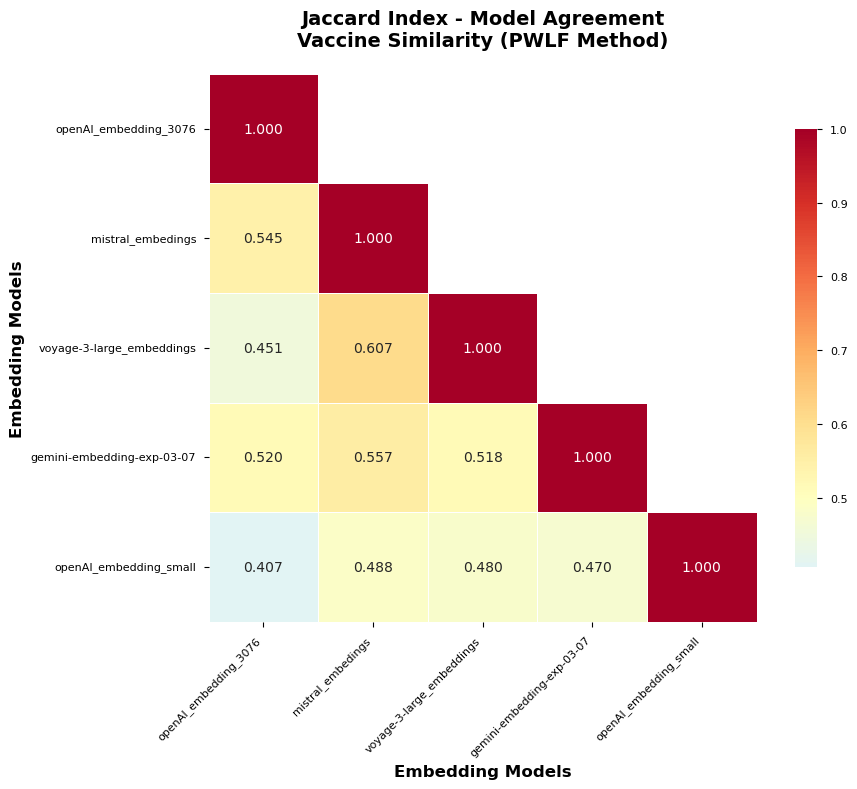


Jaccard Index Summary for vaccine_similarity:
Mean similarity (excluding diagonal): 0.504
Std similarity: 0.054
Most similar models: mistral_embedings ↔ voyage-3-large_embeddings (Jaccard: 0.607)
Least similar models: openAI_embedding_3076 ↔ openAI_embedding_small (Jaccard: 0.407)
Raw counts per model:
  openAI_embedding_3076: 365 speeches
  mistral_embedings: 554 speeches
  voyage-3-large_embeddings: 725 speeches
  gemini-embedding-exp-03-07: 556 speeches
  openAI_embedding_small: 758 speeches

=== Jaccard Index Heatmap for RUSSIAN_SIMILARITY (PWLF Method) ===


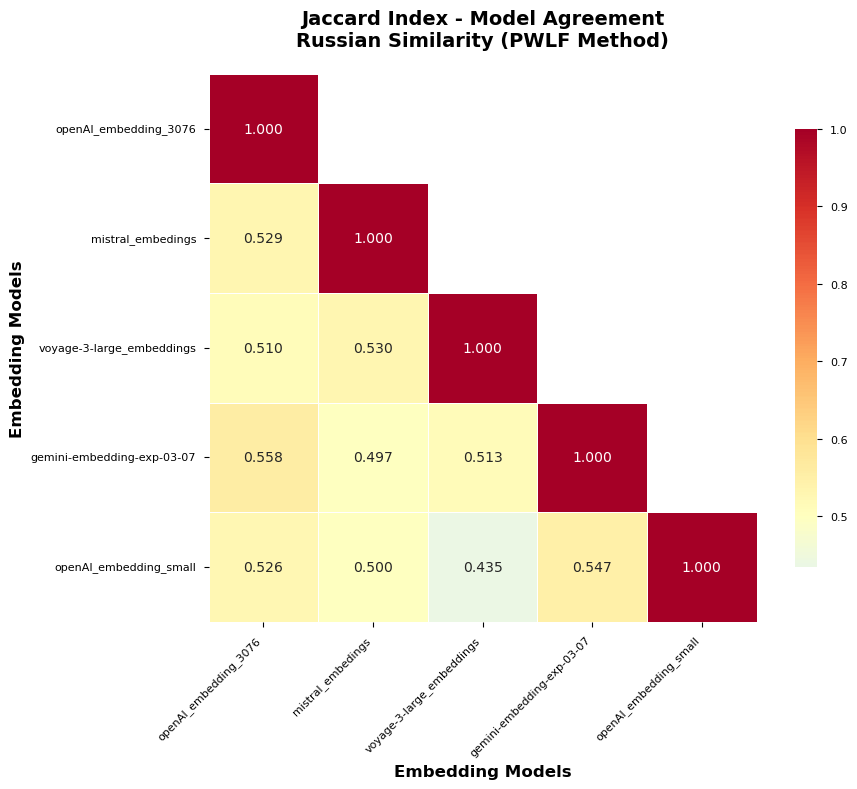


Jaccard Index Summary for russian_similarity:
Mean similarity (excluding diagonal): 0.514
Std similarity: 0.032
Most similar models: openAI_embedding_3076 ↔ gemini-embedding-exp-03-07 (Jaccard: 0.558)
Least similar models: voyage-3-large_embeddings ↔ openAI_embedding_small (Jaccard: 0.435)
Raw counts per model:
  openAI_embedding_3076: 590 speeches
  mistral_embedings: 422 speeches
  voyage-3-large_embeddings: 473 speeches
  gemini-embedding-exp-03-07: 530 speeches
  openAI_embedding_small: 448 speeches

=== Jaccard Index Heatmap for GENDER_SIMILARITY (PWLF Method) ===


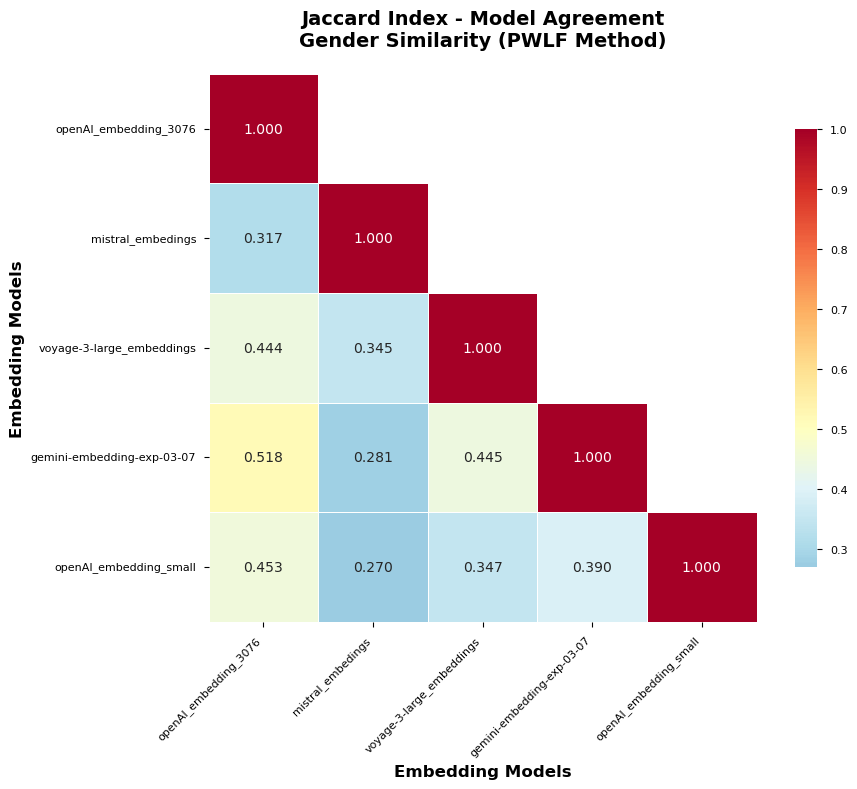


Jaccard Index Summary for gender_similarity:
Mean similarity (excluding diagonal): 0.381
Std similarity: 0.078
Most similar models: openAI_embedding_3076 ↔ gemini-embedding-exp-03-07 (Jaccard: 0.518)
Least similar models: mistral_embedings ↔ openAI_embedding_small (Jaccard: 0.270)
Raw counts per model:
  openAI_embedding_3076: 457 speeches
  mistral_embedings: 631 speeches
  voyage-3-large_embeddings: 744 speeches
  gemini-embedding-exp-03-07: 554 speeches
  openAI_embedding_small: 358 speeches

Jaccard Index Interpretation:
• 1.0 = Perfect agreement (identical speech identification)
• 0.5 = Moderate agreement (50% overlap)
• 0.0 = No agreement (no common speeches identified)


In [22]:
# Jaccard Index Heatmap for Model Comparison (PWLF method only)
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two binary sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

# For each narrative, create Jaccard similarity heatmap
for narrative in ['vaccine_similarity', 'russian_similarity', 'gender_similarity']:
    print(f"\n=== Jaccard Index Heatmap for {narrative.upper()} (PWLF Method) ===")
    
    # Get all PWLF columns for this narrative
    pwlf_cols = [col for col in df.columns if f'_{narrative}_pwlf_above_threshold' in col]
    
    if len(pwlf_cols) < 2:
        print(f"Not enough PWLF models found for {narrative} (need at least 2)")
        continue
    
    # Extract model names from column names
    model_names = []
    for col in pwlf_cols:
        model_name = col.replace(f'_{narrative}_pwlf_above_threshold', '')
        model_names.append(model_name)
    
    # Create Jaccard similarity matrix
    n_models = len(model_names)
    jaccard_matrix = np.zeros((n_models, n_models))
    
    for i in range(n_models):
        for j in range(n_models):
            if i == j:
                jaccard_matrix[i, j] = 1.0  # Perfect similarity with itself
            else:
                # Get sets of indices where each model predicts positive
                col_i = pwlf_cols[i]
                col_j = pwlf_cols[j]
                
                set_i = set(df[df[col_i] == 1].index)
                set_j = set(df[df[col_j] == 1].index)
                
                # Calculate Jaccard similarity
                jaccard_matrix[i, j] = jaccard_similarity(set_i, set_j)
    
    # Create DataFrame for better labeling
    jaccard_df = pd.DataFrame(jaccard_matrix, 
                             index=model_names, 
                             columns=model_names)
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    
    # Create mask for upper triangle (optional - to show only lower triangle)
    mask = np.triu(np.ones_like(jaccard_df), k=1)
    
    sns.heatmap(jaccard_df, 
                annot=True, 
                cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (red=low, blue=high)
                center=0.5,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8},
                fmt='.3f',
                mask=mask)  # Remove this line if you want full matrix
    
    plt.title(f'Jaccard Index - Model Agreement\n{narrative.replace("_", " ").title()} (PWLF Method)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Embedding Models', fontsize=12, fontweight='bold')
    plt.ylabel('Embedding Models', fontsize=12, fontweight='bold')
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(rf"..\graphs\slovak_parliament_{narrative}_jaccard_heatmap.png")
    plt.show()
    
    # Print summary statistics
    print(f"\nJaccard Index Summary for {narrative}:")
    print(f"Mean similarity (excluding diagonal): {jaccard_df.values[~np.eye(n_models, dtype=bool)].mean():.3f}")
    print(f"Std similarity: {jaccard_df.values[~np.eye(n_models, dtype=bool)].std():.3f}")
    
    # Find most similar pair
    max_val = 0
    max_pair = None
    for i in range(n_models):
        for j in range(i+1, n_models):
            if jaccard_df.iloc[i, j] > max_val:
                max_val = jaccard_df.iloc[i, j]
                max_pair = (model_names[i], model_names[j])
    
    if max_pair:
        print(f"Most similar models: {max_pair[0]} ↔ {max_pair[1]} (Jaccard: {max_val:.3f})")
    
    # Find least similar pair
    min_val = 1.0
    min_pair = None
    for i in range(n_models):
        for j in range(i+1, n_models):
            if jaccard_df.iloc[i, j] < min_val:
                min_val = jaccard_df.iloc[i, j]
                min_pair = (model_names[i], model_names[j])
    
    if min_pair:
        print(f"Least similar models: {min_pair[0]} ↔ {min_pair[1]} (Jaccard: {min_val:.3f})")
    
    print(f"Raw counts per model:")
    for i, model in enumerate(model_names):
        count = df[pwlf_cols[i]].sum()
        print(f"  {model}: {count} speeches")

print("\n" + "="*60)
print("Jaccard Index Interpretation:")
print("• 1.0 = Perfect agreement (identical speech identification)")
print("• 0.5 = Moderate agreement (50% overlap)")  
print("• 0.0 = No agreement (no common speeches identified)")
print("="*60)

# Sample Selection for Manual Annotation

This section defines a systematic sampling protocol to evaluate the effectiveness of sentence-embedding models and LLMs on Slovak parliamentary transcripts (2020–2023). The objective is to curate **representative** and **challenging** cases for manual labeling, emphasizing two sample types:

- **Lowest-scoring positives above threshold** — candidates for potential false positives per model/narrative.
- **Unique disagreements** — speeches where exactly one model predicts the narrative (positive) while all others predict negative.

## Sampling Workflow

1. For each embedding model and narrative, select the lowest **N** speeches **above** the model-specific semantic threshold.  
2. Identify up to **UNIQUE_N** speeches per model/narrative where only that model flags the narrative.  
3. Track sampled indices to eliminate duplicates across draws.  
4. Shuffle and concatenate all sampled subsets to optimize the annotator’s workflow.

## Outputs

- Summary statistics by **sample type**, **narrative**, and **political club**.  
- A preview table of collected samples for annotation.  
- Diagnostics on **unique model disagreements**.  
- Enhanced save/checkpointing to support **reproducibility**.

# Manual Annotation Interface

A compact tool (`CompactAnnotator`) is provided for efficient labeling of sampled speeches. Key features:

- Clear presentation of speech text, metadata, and narrative context.  
- Keyboard commands: **YES / NO / skip / prev / save / quit**.  
- Progress tracking with periodic **autosave**.

# Manual Annotation Analysis

Post-annotation, the notebook evaluates narrative detection across models and sample types:

- **Progress statistics**: counts of annotated items, positive/negative labels.  
- **Stacked bar charts**: manual results for “lowest” and “unique” samples by narrative and model.  
- **Performance breakdowns**: accuracy (and related metrics) by sample type, model, and narrative.  
- **Quartile analysis**: agreement patterns across each model’s own score distribution.  
- **Uniqueness overlap**: number of models agreeing on each positive prediction.

# Model Agreement Columns

For each narrative, new columns record how many models labeled a speech as positive. These enable selection of **high-confidence** subsets (e.g., items agreed upon by 4/5 models) for downstream LLM testing.

# Project Context & Coding Guidelines

- **Focus**: Measuring the effectiveness of embeddings and LLMs on Slovak parliamentary data.  
- **Corpus**: 2010–2023 parliamentary speeches with rich metadata and multiple embedding vectors.  
- **Engineering**: Modular, well-documented code designed for **clarity** and **reproducibility**.  
- **Visualization**: Outputs tailored for academic analysis of Slovak political narratives.

# Next Steps

Use the annotated and agreement-filtered samples for downstream **LLM evaluation** and further research on **narrative detection in low-resource languages**.


In [ ]:

samples = []

# Configuration for Slovak parliamentary speech analysis
LOWEST_N = 2   # Number of lowest scoring speeches to sample per model/narrative
UNIQUE_N = 6   # Number of unique disagreement texts per model/narrative
RANDOM_SEED = 42

# Track already sampled speeches to avoid duplicates across sample types
sampled_indices = set()

for model, emb_col in embedding_models.items():
    for narrative in narratives_dict.keys():
        # Check for PWLF threshold columns
        score_col = f"{emb_col}_{narrative}_cosine_score"
        flag_col = f"{model}_{narrative}_pwlf_above_threshold"
        
        if score_col not in df.columns or flag_col not in df.columns:
            print(f"⚠️ Skipping {model}-{narrative}: missing columns")
            continue

        # --- 1. LOWEST SCORING SPEECHES ---
        above_threshold = df[df[flag_col] == 1].copy()
        
        if len(above_threshold) > 0:
            # Get the lowest N scoring speeches above threshold
            lowest_scores = (
                above_threshold
                .nsmallest(LOWEST_N, score_col)
                .assign(
                    model=model,
                    narrative=narrative,
                    score=lambda x: x[score_col],
                    sample_type='lowest',  # Mark as lowest scoring
                    manual_label=np.nan
                )
                [['model', 'narrative', 'score', 'prepis', 'klub', 'poslanec', 'sample_type', 'manual_label']]
            )
            
            # Track sampled indices
            sampled_indices.update(above_threshold.nsmallest(LOWEST_N, score_col).index)
        
            samples.append(lowest_scores)

            print(f"✅ Added {len(lowest_scores)} LOWEST samples from {model}-{narrative}")

        # --- 2. UNIQUE DISAGREEMENTS ---
        # Find speeches where this model says YES but ALL others say NO
        this_model_positive = df[df[flag_col] == 1]
        
        if len(this_model_positive) == 0:
            print(f"ℹ️ No positive predictions for {model}-{narrative}")
            continue
            
        # Check other models for this narrative
        other_models = [m for m in embedding_models.keys() if m != model]
        unique_mask = np.ones(len(this_model_positive), dtype=bool)
        
        for other_model in other_models:
            other_flag_col = f"{other_model}_{narrative}_pwlf_above_threshold"
            if other_flag_col in df.columns:
                # Get the predictions for the same speeches from other model
                other_predictions = df.loc[this_model_positive.index, other_flag_col]
                # Keep only speeches where other model says NO (0)
                unique_mask &= (other_predictions == 0)
        
        # Get unique disagreements for this model
        unique_disagreements = this_model_positive[unique_mask]
        
        if len(unique_disagreements) > 0:
            # Sample up to UNIQUE_N speeches
            if len(unique_disagreements) > UNIQUE_N:
                unique_sample = unique_disagreements.sample(UNIQUE_N, random_state=RANDOM_SEED)
            else:
                unique_sample = unique_disagreements
            
            # Add to samples with proper labeling
            unique_samples = (
                unique_sample
                .assign(
                    model=model,
                    narrative=narrative,
                    score=unique_sample[score_col],
                    sample_type='unique',  # Mark as unique disagreement
                    manual_label=np.nan
                )
                [['model', 'narrative', 'score', 'prepis', 'klub', 'poslanec', 'sample_type', 'manual_label']]
            )
            
            # Track sampled indices
            sampled_indices.update(unique_sample.index)
            
            samples.append(unique_samples)
            print(f"🔀 Added {len(unique_samples)} UNIQUE samples from {model}-{narrative}")
        else:
            print(f"ℹ️ No unique disagreements found for {model}-{narrative}")


if samples:
    # Combine all samples for Slovak parliamentary embedding analysis
    samples_df = pd.concat(samples, ignore_index=True)
    
    # Enhanced shuffle strategy: group by sample_type for better annotation experience
    lowest_samples = samples_df[samples_df['sample_type'] == 'lowest'].sample(frac=1, random_state=RANDOM_SEED)
    unique_samples = samples_df[samples_df['sample_type'] == 'unique'].sample(frac=1, random_state=RANDOM_SEED)
    
    
    # Combine with optimal order for Slovak parliamentary speech annotation
    samples_df = pd.concat([lowest_samples, unique_samples], ignore_index=True)

    print(f"\n🎉 SLOVAK PARLIAMENTARY EMBEDDING ANALYSIS - SAMPLE COLLECTION COMPLETE")
    print(f"✅ Collected {len(samples_df)} total samples for manual annotation")
    
    print(f"\n📊 SUMMARY BY SAMPLE TYPE:")
    sample_type_summary = samples_df.groupby('sample_type').size()
    for sample_type, count in sample_type_summary.items():
        sample_type_desc = {
            'lowest': 'Lowest scoring speeches above threshold (potential false positives)',
            'unique': 'Speeches where only one model predicts positive (model disagreements)', 
            'method_narrative': 'Representative speeches per method-narrative combination'
        }
        print(f"  {sample_type.upper()}: {count} samples")
        print(f"    → {sample_type_desc.get(sample_type, 'Unknown sample type')}")
    
    print(f"\n📈 BREAKDOWN BY POLITICAL NARRATIVE:")
    for narrative in narratives_dict.keys():
        narrative_data = samples_df[samples_df['narrative'] == narrative]
        if len(narrative_data) > 0:
            lowest_count = len(narrative_data[narrative_data['sample_type'] == 'lowest'])
            unique_count = len(narrative_data[narrative_data['sample_type'] == 'unique'])

            
            narrative_clean = narrative.replace('_similarity', '').title()
            print(f"  {narrative_clean}: {len(narrative_data)} total")
            print(f"    → Lowest: {lowest_count}, Unique: {unique_count}")

    
    print(f"\n🏛️ BREAKDOWN BY POLITICAL CLUB (Slovak Parliament):")
    klub_summary = samples_df['klub'].value_counts()
    for klub, count in klub_summary.head(10).items():  # Show top 10 clubs
        print(f"  {klub}: {count} speeches")
    if len(klub_summary) > 10:
        print(f"  ... and {len(klub_summary) - 10} other clubs")
    
    print(f"\n📋 SAMPLE PREVIEW FOR SLOVAK PARLIAMENTARY ANALYSIS:")
    display(samples_df.head(10))
    
    print(f"\n🔍 DETAILED ANALYSIS:")
    
    # Unique disagreements analysis
    unique_data = samples_df[samples_df['sample_type'] == 'unique']
    if len(unique_data) > 0:
        print(f"📊 Models with unique predictions (embedding model disagreements):")
        unique_by_model = unique_data.groupby(['model', 'narrative']).size().reset_index(name='count')
        for _, row in unique_by_model.iterrows():
            narrative_clean = row['narrative'].replace('_similarity', '')
            print(f"  {row['model']} - {narrative_clean}: {row['count']} unique speeches")
    else:
        print("  ℹ️ No unique disagreements found.")
    
    # Method-narrative analysis
    method_narrative_data = samples_df[samples_df['sample_type'] == 'method_narrative']
    if len(method_narrative_data) > 0:
        print(f"\n📊 Method-narrative representative samples:")
        mn_summary = method_narrative_data.groupby(['method', 'narrative']).size().reset_index(name='count')
        for _, row in mn_summary.iterrows():
            narrative_clean = row['narrative'].replace('_similarity', '')
            print(f"  {row['method'].upper()} - {narrative_clean}: {row['count']} representative speeches")
    
    # Enhanced save functionality with updated columns
    print(f"\n💾 ENHANCED SAVE FUNCTIONALITY:")
    print(f"When saved, CSV will include Slovak parliamentary context:")
    print(f"  • Basic columns: klub, prepis, poslanec, manual_label")
    print(f"  • Analysis columns: model, narrative,  score, sample_type") 
    print(f"  • Summary columns: is_lowest, is_unique")
    
else:
    print("❌ No samples collected. Check if threshold columns exist for Slovak parliamentary data.")
    samples_df = pd.DataFrame()

In [ ]:
# Fixed Slovak Parliamentary Speech Annotator - No More Display Issues
class CompactAnnotator:
    def __init__(self, df, name="slovak_parliament"):
        self.df = df.copy()
        self.name = name
        self.idx = 0
        if 'manual_label' not in self.df.columns:
            self.df['manual_label'] = np.nan
    
    def _display_narrative(self, clear_first=True):
        """Display current narrative - internal method"""
        if self.idx >= len(self.df):
            print("🎉 Complete! Use save() to save results.")
            return False
        
        # Only clear on first display or when explicitly requested
        if clear_first:
            try:
                from IPython.display import clear_output
                clear_output(wait=True)
            except:
                pass
        
        r = self.df.iloc[self.idx]
        narrative_clean = r.narrative.replace('_similarity', '').upper()
        
        # Always show complete current narrative info
        print("\n" + "="*80)
        print(f"SLOVAK PARLIAMENTARY SPEECH ANNOTATION")
        print(f"[{self.idx+1}/{len(self.df)}] {narrative_clean} NARRATIVE")
        print(f"Club: {r.klub} | Speaker: {r.poslanec}")
        print(f"Model: {r.model} | Score: {r.score:.3f} | Type: {r.sample_type}")
        print("="*80)
        
        # Format speech text clearly
        words = str(r.prepis).split()
        for i in range(0, len(words), 12):
            row_words = words[i:i + 12]
            print(f"{(i//12)+1:2d}: {' '.join(row_words)}")
        
        print("="*80)
        print(f"❓ QUESTION: Does this speech express {narrative_clean} narrative?")
        print("📝 COMMANDS: 1=YES, 0=NO, s=skip, p=prev, save=save, q=quit")
        print("="*80)
        return True
    
    def show_current(self):
        """Public method to show current narrative"""
        return self._display_narrative(clear_first=True)
    
    def annotate(self):
        """Main annotation loop - FIXED display AND scrolling issue"""
        import time
        
        # Show first narrative
        if not self._display_narrative(clear_first=True):
            return
            
        while self.idx < len(self.df):
            try:
                cmd = input(f"👉 [{self.idx+1}] Your label: ").strip().lower()
                
                if cmd == '1':
                    self.df.iloc[self.idx, self.df.columns.get_loc('manual_label')] = 1
                    print("✅ Labeled as YES - Moving to next...")
                    time.sleep(0.8)  # Brief pause to see confirmation
                    self.idx += 1
                    # Clear screen and show next narrative
                    if not self._display_narrative(clear_first=True):
                        break
                        
                elif cmd == '0':
                    self.df.iloc[self.idx, self.df.columns.get_loc('manual_label')] = 0
                    print("❌ Labeled as NO - Moving to next...")
                    time.sleep(0.8)  # Brief pause to see confirmation
                    self.idx += 1
                    # Clear screen and show next narrative
                    if not self._display_narrative(clear_first=True):
                        break
                        
                elif cmd == 's':
                    print("⏭️ Skipping - Moving to next...")
                    time.sleep(0.5)  # Brief pause
                    self.idx += 1
                    # Clear screen and show next narrative
                    if not self._display_narrative(clear_first=True):
                        break
                        
                elif cmd == 'p':
                    if self.idx > 0:
                        self.idx -= 1
                        print("⬅️ Going to previous...")
                        time.sleep(0.5)
                        # Clear screen for previous navigation
                        self._display_narrative(clear_first=True)
                    else:
                        print("📍 Already at first narrative")
                        
                elif cmd == 'save':
                    print("💾 Saving progress...")
                    self.save()
                    print("📍 Continuing with current narrative...")
                    time.sleep(1)
                    # Show current narrative cleanly
                    self._display_narrative(clear_first=True)
                    
                elif cmd == 'q':
                    print("🚪 Quitting annotation...")
                    break
                    
                else:
                    print("❌ Invalid command! Use: 1, 0, s, p, save, q")
                    print("Current narrative remains displayed above.")
                    
            except KeyboardInterrupt:
                print("\n⚠️ Interrupted. Type 'save' to save progress.")
                break
        
        # Final status
        print(f"\n📊 ANNOTATION SESSION COMPLETE")
        print(f"Position: {self.idx+1}/{len(self.df)}")
        annotated = self.df['manual_label'].notna().sum()
        print(f"Progress: {annotated} narratives annotated")
    
    def save(self):
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        filename = f"../data/annotated_slovak_{self.name}_{timestamp}.csv"
        self.df.to_csv(filename, index=False, encoding='utf-8')
        
        annotated = self.df['manual_label'].notna().sum()
        positive = (self.df['manual_label'] == 1).sum()
        print(f"💾 SAVED: {filename}")
        print(f"📊 Progress: {annotated}/{len(self.df)} ({annotated/len(self.df)*100:.1f}%)")
        if annotated > 0:
            print(f"✅ Positive: {positive} ({positive/annotated*100:.1f}% of annotated)")
    
    def get_df(self):
        return self.df


In [ ]:
# Create FINAL FIXED annotator instance (display + scrolling solved!)
print("🎯 FINAL ANNOTATOR READY!")
print("✅ After labeling: brief confirmation → auto-clear → next narrative at top")
print("✅ No scrolling needed - each narrative appears cleanly at the top")
print("✅ Perfect annotation workflow!")
print("🚀 Run: compact_annotator.annotate()")

compact_annotator = CompactAnnotator(samples_df)


🎯 FINAL ANNOTATOR READY!
✅ After labeling: brief confirmation → auto-clear → next narrative at top
✅ No scrolling needed - each narrative appears cleanly at the top
✅ Perfect annotation workflow!
🚀 Run: compact_annotator.annotate()


In [ ]:
compact_annotator.annotate()


SLOVAK PARLIAMENTARY SPEECH ANNOTATION
[116/116] VACCINE NARRATIVE
Club: (SMER - SD) | Speaker: Blanár, Juraj
Model: gemini-embedding-exp-03-07 | Score: 0.723 | Type: unique
 1: 69.Ďakujem. Vážený pán predsedajúci, ctená snemovňa, vážené pani poslankyne, páni poslanci, pán
 2: predseda vlády, vážená vláda Slovenskej republiky, požiadal som o slovo, aby som
 3: mohol vystúpiť ešte pred ministrami, pretože je potrebné povedať fakty, ktoré tu
 4: musia zaznieť. Prečo sa schádzame pri tomto programovom vyhlásení staronovej vlády Igora
 5: Matoviča? No preto sa schádzame tu, pretože tá minulá vláda absolútne zlyhala.My
 6: rešpektujeme, pán predseda vlády, že vláda môže predložiť to isté programové vyhlásenie
 7: vlády, avšak musíme povedať a naliať čistého vína, aká bola pravda. Namiesto
 8: toho, aby ste prejavili určitú dávku sebareflexie pri predkladaní toho staronového programového
 9: vyhlásenia vlády, ktoré ste napokon chceli ho nejakým spôsobom upravovať, ale predsa
10: ste ho pred

In [ ]:
compact_annotator.save()

💾 SAVED: ../data/annotated_slovak_slovak_parliament_20250829_1556.csv
📊 Progress: 115/116 (99.1%)
✅ Positive: 45 (39.1% of annotated)


In [ ]:
# Load annotated samples for analysis
# Use the annotated data from the compact_annotator or load from saved CSV

# Check if we have annotated data in memory
if 'compact_annotator' in globals() and hasattr(compact_annotator, 'df'):
    annotated_df = compact_annotator.get_df().copy()
    print("✅ Using annotated data from current session")
else:
    # If no annotator in memory, check if anontate_sample exists (from your variable list)
    if 'anontate_sample' in globals():
        annotated_df = anontate_sample.copy()
        print("✅ Using anontate_sample variable")
    else:
        # Try to load most recent CSV file
        import glob
        csv_files = glob.glob("../data/annotated_slovak_*.csv")
        if csv_files:
            latest_file = max(csv_files, key=os.path.getctime)
            annotated_df = pd.read_csv(latest_file)
            print(f"✅ Loaded from {latest_file}")
        else:
            print("❌ No annotated data found!")
            annotated_df = samples_df.copy()  # Fallback to original samples

# Basic info about annotation progress
total_samples = len(annotated_df)
annotated_count = annotated_df['manual_label'].notna().sum()
positive_count = (annotated_df['manual_label'] == 1).sum()
negative_count = (annotated_df['manual_label'] == 0).sum()

print(f"\n📊 ANNOTATION PROGRESS:")
print(f"Total samples: {total_samples}")
print(f"Annotated: {annotated_count} ({annotated_count/total_samples*100:.1f}%)")
print(f"Positive (YES): {positive_count}")
print(f"Negative (NO): {negative_count}")

# Check data structure
print(f"\n📋 DATA STRUCTURE:")
print(f"Columns: {list(annotated_df.columns)}")
print(f"Sample types: {annotated_df['sample_type'].value_counts().to_dict()}")
print(f"Narratives: {annotated_df['narrative'].value_counts().to_dict()}")

# Display a few annotated samples
annotated_samples = annotated_df[annotated_df['manual_label'].notna()]
if len(annotated_samples) > 0:
    print(f"\n🔍 PREVIEW OF ANNOTATED SAMPLES:")
    display(annotated_samples[['narrative', 'model', 'sample_type', 'manual_label', 'klub']].head())
else:
    print(f"\n⚠️ No manually labeled samples found yet.")
    print(f"Use compact_annotator.annotate() to start labeling.")

✅ Loaded from ../data\annotated_slovak_slovak_parliament_20250829_1556.csv

📊 ANNOTATION PROGRESS:
Total samples: 116
Annotated: 115 (99.1%)
Positive (YES): 45
Negative (NO): 70

📋 DATA STRUCTURE:
Columns: ['model', 'narrative', 'score', 'prepis', 'klub', 'poslanec', 'sample_type', 'manual_label']
Sample types: {'unique': 86, 'lowest': 30}
Narratives: {'russian_similarity': 40, 'gender_similarity': 40, 'vaccine_similarity': 36}

🔍 PREVIEW OF ANNOTATED SAMPLES:


,narrative,model,sample_type,manual_label,klub
0,russian_similarity,openAI_embedding_small,lowest,0.0,(ĽS Naše Slovensko)
1,russian_similarity,voyage-3-large_embeddings,lowest,0.0,(OĽANO)
2,gender_similarity,gemini-embedding-exp-03-07,lowest,0.0,(ĽS Naše Slovensko)
3,gender_similarity,voyage-3-large_embeddings,lowest,0.0,(-)
4,russian_similarity,mistral_embedings,lowest,0.0,(OĽANO)


📊 GRAPH 1: Manual Annotation Results - LOWEST Scoring Samples


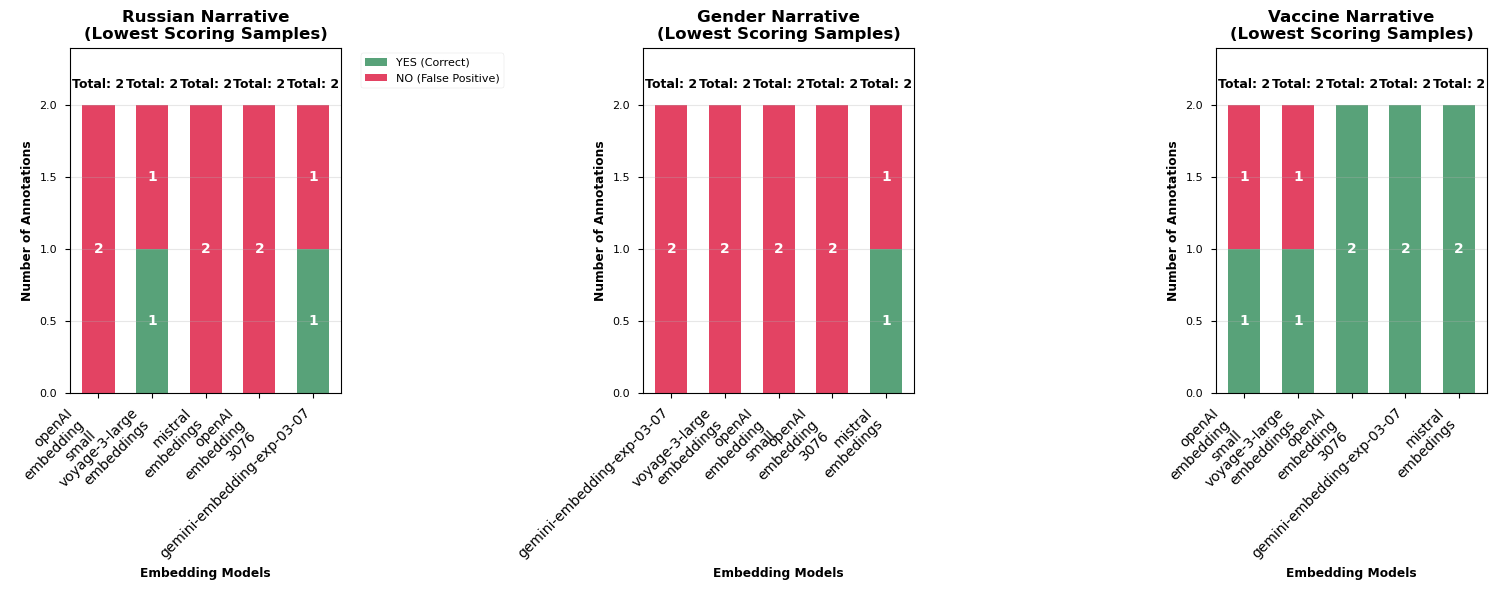


📈 SUMMARY - LOWEST SCORING SAMPLES:
  Russian: 2/10 correct (20.0%), 8 false positives
  Gender: 1/10 correct (10.0%), 9 false positives
  Vaccine: 8/10 correct (80.0%), 2 false positives

🎯 OVERALL ACCURACY (Lowest Samples): 11/30 = 36.7%
🔍 INTERPRETATION: This shows how many 'lowest scoring' speeches were actually correct narratives


In [ ]:
# GRAPH 1: Stacked Bar Chart - Manual Labels by Sample Method for "LOWEST" samples
# For each narrative, show manual annotation results (YES/NO) stacked by method for "lowest" sample type

print("📊 GRAPH 1: Manual Annotation Results - LOWEST Scoring Samples")
print("="*70)

# Filter for only annotated "lowest" samples
lowest_annotated = annotated_df[
    (annotated_df['sample_type'] == 'lowest') & 
    (annotated_df['manual_label'].notna())
]

if len(lowest_annotated) == 0:
    print("⚠️ No annotated 'lowest' samples found yet.")
    print("Continue annotation with compact_annotator.annotate() to generate this graph.")
else:
    # Create separate plots for each narrative
    narratives = lowest_annotated['narrative'].unique()
    
    fig, axes = plt.subplots(1, len(narratives), figsize=(5*len(narratives), 6))
    if len(narratives) == 1:
        axes = [axes]  # Make it iterable for single narrative
    
    colors = {'YES': '#2E8B57', 'NO': '#DC143C', 'Unlabeled': '#A9A9A9'}
    
    for idx, narrative in enumerate(narratives):
        ax = axes[idx]
        narrative_data = lowest_annotated[lowest_annotated['narrative'] == narrative]
        
        # Get unique models for this narrative
        models = narrative_data['model'].unique()
        
        # Prepare data for stacking
        yes_counts = []
        no_counts = []
        model_labels = []
        
        for model in models:
            model_data = narrative_data[narrative_data['model'] == model]
            yes_count = (model_data['manual_label'] == 1).sum()
            no_count = (model_data['manual_label'] == 0).sum()
            
            yes_counts.append(yes_count)
            no_counts.append(no_count)
            model_labels.append(model.replace('_', '\n'))
        
        # Create stacked bar chart
        x_pos = np.arange(len(models))
        width = 0.6
        
        # Stack the bars
        p1 = ax.bar(x_pos, yes_counts, width, label='YES (Correct)', color=colors['YES'], alpha=0.8)
        p2 = ax.bar(x_pos, no_counts, width, bottom=yes_counts, label='NO (False Positive)', color=colors['NO'], alpha=0.8)
        
        # Customize the plot
        narrative_clean = narrative.replace('_similarity', '').title()
        ax.set_title(f'{narrative_clean} Narrative\n(Lowest Scoring Samples)', fontweight='bold', fontsize=12)
        ax.set_xlabel('Embedding Models', fontweight='bold')
        ax.set_ylabel('Number of Annotations', fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=10)
        
        # Add value labels on bars
        for i, (yes, no) in enumerate(zip(yes_counts, no_counts)):
            total = yes + no
            if yes > 0:
                ax.text(i, yes/2, f'{yes}', ha='center', va='center', fontweight='bold', color='white')
            if no > 0:
                ax.text(i, yes + no/2, f'{no}', ha='center', va='center', fontweight='bold', color='white')
            if total > 0:
                ax.text(i, total + 0.1, f'Total: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Add legend only to first subplot
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Grid for better readability
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, max([sum(pair) for pair in zip(yes_counts, no_counts)]) * 1.2 if any(yes_counts) or any(no_counts) else 1)
    
    plt.tight_layout()
    plt.savefig('../graphs/manual_annotation_lowest_samples_by_narrative.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    print(f"\n📈 SUMMARY - LOWEST SCORING SAMPLES:")
    for narrative in narratives:
        narrative_data = lowest_annotated[lowest_annotated['narrative'] == narrative]
        narrative_clean = narrative.replace('_similarity', '').title()
        
        total = len(narrative_data)
        correct = (narrative_data['manual_label'] == 1).sum()
        false_pos = (narrative_data['manual_label'] == 0).sum()
        accuracy = correct / total * 100 if total > 0 else 0
        
        print(f"  {narrative_clean}: {correct}/{total} correct ({accuracy:.1f}%), {false_pos} false positives")
    
    # Overall accuracy for lowest samples
    if len(lowest_annotated) > 0:
        overall_correct = (lowest_annotated['manual_label'] == 1).sum()
        overall_total = len(lowest_annotated)
        overall_accuracy = overall_correct / overall_total * 100
        print(f"\n🎯 OVERALL ACCURACY (Lowest Samples): {overall_correct}/{overall_total} = {overall_accuracy:.1f}%")
        print(f"🔍 INTERPRETATION: This shows how many 'lowest scoring' speeches were actually correct narratives")

📊 GRAPH 2: Manual Annotation Results - UNIQUE Disagreement Samples


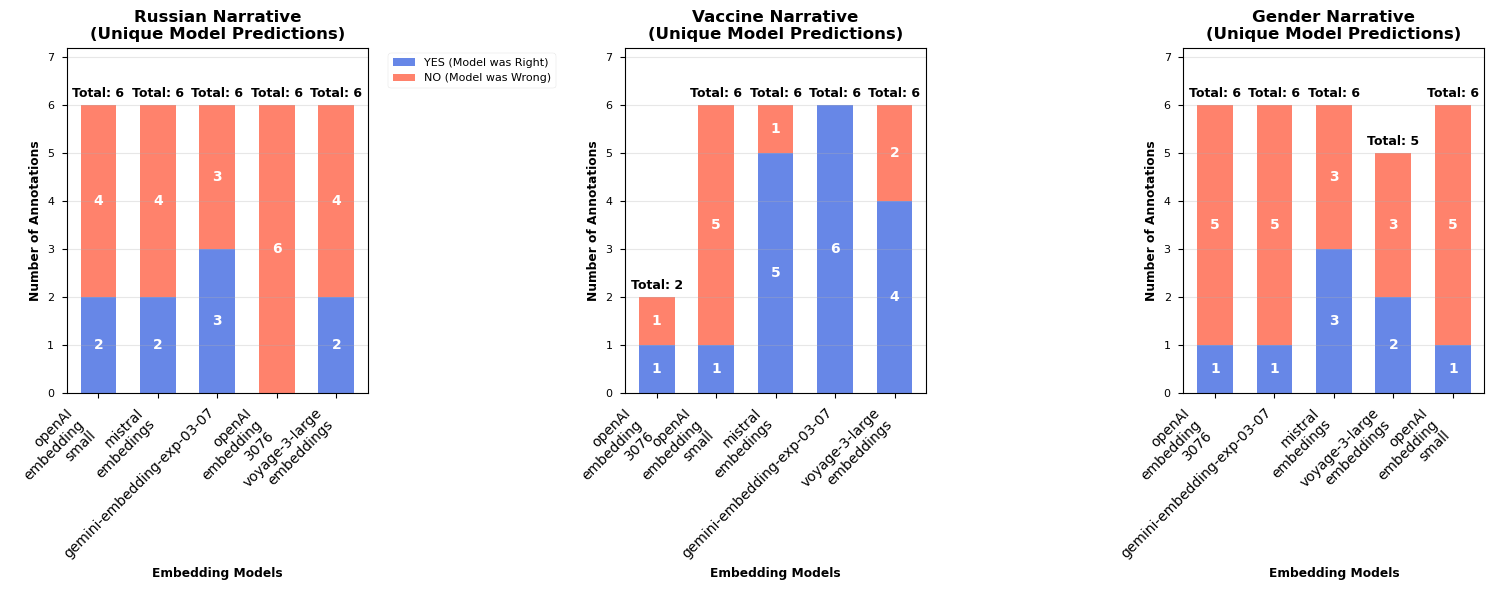


📈 SUMMARY - UNIQUE MODEL PREDICTIONS:
  openAI_embedding_small - Russian: 2/6 correct unique predictions (33.3%)
  mistral_embedings - Russian: 2/6 correct unique predictions (33.3%)
  gemini-embedding-exp-03-07 - Russian: 3/6 correct unique predictions (50.0%)
  openAI_embedding_3076 - Russian: 0/6 correct unique predictions (0.0%)
  voyage-3-large_embeddings - Russian: 2/6 correct unique predictions (33.3%)
  openAI_embedding_3076 - Vaccine: 1/2 correct unique predictions (50.0%)
  openAI_embedding_small - Vaccine: 1/6 correct unique predictions (16.7%)
  mistral_embedings - Vaccine: 5/6 correct unique predictions (83.3%)
  gemini-embedding-exp-03-07 - Vaccine: 6/6 correct unique predictions (100.0%)
  voyage-3-large_embeddings - Vaccine: 4/6 correct unique predictions (66.7%)
  openAI_embedding_3076 - Gender: 1/6 correct unique predictions (16.7%)
  gemini-embedding-exp-03-07 - Gender: 1/6 correct unique predictions (16.7%)
  mistral_embedings - Gender: 3/6 correct unique predictio

In [ ]:
# GRAPH 2: Stacked Bar Chart - Manual Labels by Sample Method for "UNIQUE" samples  
# For each narrative, show manual annotation results (YES/NO) stacked by method for "unique" sample type

print("📊 GRAPH 2: Manual Annotation Results - UNIQUE Disagreement Samples")
print("="*70)

# Filter for only annotated "unique" samples
unique_annotated = annotated_df[
    (annotated_df['sample_type'] == 'unique') & 
    (annotated_df['manual_label'].notna())
]

if len(unique_annotated) == 0:
    print("⚠️ No annotated 'unique' samples found yet.")
    print("Continue annotation with compact_annotator.annotate() to generate this graph.")
else:
    # Create separate plots for each narrative
    narratives = unique_annotated['narrative'].unique()
    
    fig, axes = plt.subplots(1, len(narratives), figsize=(5*len(narratives), 6))
    if len(narratives) == 1:
        axes = [axes]  # Make it iterable for single narrative
    
    colors = {'YES': '#4169E1', 'NO': '#FF6347', 'Unlabeled': '#A9A9A9'}
    
    for idx, narrative in enumerate(narratives):
        ax = axes[idx]
        narrative_data = unique_annotated[unique_annotated['narrative'] == narrative]
        
        # Get unique models for this narrative (models that had unique predictions)
        models = narrative_data['model'].unique()
        
        # Prepare data for stacking
        yes_counts = []
        no_counts = []
        model_labels = []
        
        for model in models:
            model_data = narrative_data[narrative_data['model'] == model]
            yes_count = (model_data['manual_label'] == 1).sum()
            no_count = (model_data['manual_label'] == 0).sum()
            
            yes_counts.append(yes_count)
            no_counts.append(no_count)
            model_labels.append(model.replace('_', '\n'))
        
        # Create stacked bar chart
        x_pos = np.arange(len(models))
        width = 0.6
        
        # Stack the bars
        p1 = ax.bar(x_pos, yes_counts, width, label='YES (Model was Right)', color=colors['YES'], alpha=0.8)
        p2 = ax.bar(x_pos, no_counts, width, bottom=yes_counts, label='NO (Model was Wrong)', color=colors['NO'], alpha=0.8)
        
        # Customize the plot
        narrative_clean = narrative.replace('_similarity', '').title()
        ax.set_title(f'{narrative_clean} Narrative\n(Unique Model Predictions)', fontweight='bold', fontsize=12)
        ax.set_xlabel('Embedding Models', fontweight='bold')
        ax.set_ylabel('Number of Annotations', fontweight='bold')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_labels, rotation=45, ha='right', fontsize=10)
        
        # Add value labels on bars
        for i, (yes, no) in enumerate(zip(yes_counts, no_counts)):
            total = yes + no
            if yes > 0:
                ax.text(i, yes/2, f'{yes}', ha='center', va='center', fontweight='bold', color='white')
            if no > 0:
                ax.text(i, yes + no/2, f'{no}', ha='center', va='center', fontweight='bold', color='white')
            if total > 0:
                ax.text(i, total + 0.1, f'Total: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Add legend only to first subplot
        if idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Grid for better readability
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, max([sum(pair) for pair in zip(yes_counts, no_counts)]) * 1.2 if any(yes_counts) or any(no_counts) else 1)
    
    plt.tight_layout()
    plt.savefig('../graphs/manual_annotation_unique_samples_by_narrative.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics for unique predictions
    print(f"\n📈 SUMMARY - UNIQUE MODEL PREDICTIONS:")
    for narrative in narratives:
        narrative_data = unique_annotated[unique_annotated['narrative'] == narrative]
        narrative_clean = narrative.replace('_similarity', '').title()
        
        # Analysis by model
        models = narrative_data['model'].unique()
        for model in models:
            model_data = narrative_data[narrative_data['model'] == model]
            total = len(model_data)
            correct = (model_data['manual_label'] == 1).sum()
            wrong = (model_data['manual_label'] == 0).sum()
            accuracy = correct / total * 100 if total > 0 else 0
            
            print(f"  {model} - {narrative_clean}: {correct}/{total} correct unique predictions ({accuracy:.1f}%)")
    
    # Overall accuracy for unique samples
    if len(unique_annotated) > 0:
        overall_correct = (unique_annotated['manual_label'] == 1).sum()
        overall_total = len(unique_annotated)
        overall_accuracy = overall_correct / overall_total * 100
        print(f"\n🎯 OVERALL UNIQUE PREDICTION ACCURACY: {overall_correct}/{overall_total} = {overall_accuracy:.1f}%")
        print(f"🔍 INTERPRETATION: This shows how often models were right when they disagreed with other models")

In [ ]:
# COMPREHENSIVE ANALYSIS: Comparison Between Sample Types and Model Performance

print("📊 COMPREHENSIVE MANUAL ANNOTATION ANALYSIS")
print("="*70)

# Get all annotated samples
all_annotated = annotated_df[annotated_df['manual_label'].notna()]

if len(all_annotated) > 0:
    
    # 1. Sample Type Comparison
    print(f"\n1️⃣ SAMPLE TYPE EFFECTIVENESS:")
    print("-" * 50)
    
    sample_types = all_annotated['sample_type'].unique()
    for sample_type in sample_types:
        type_data = all_annotated[all_annotated['sample_type'] == sample_type]
        total = len(type_data)
        correct = (type_data['manual_label'] == 1).sum()
        accuracy = correct / total * 100 if total > 0 else 0
        
        sample_desc = {
            'lowest': 'Lowest scoring above threshold (potential false positives)',
            'unique': 'Unique model disagreements (one model says YES, others NO)',
            'method_narrative': 'Representative samples per method-narrative'
        }
        
        print(f"  {sample_type.upper()}: {correct}/{total} correct ({accuracy:.1f}%)")
        print(f"    → {sample_desc.get(sample_type, 'Unknown type')}")
    
    # 2. Model Performance Comparison
    print(f"\n2️⃣ EMBEDDING MODEL PERFORMANCE:")
    print("-" * 50)
    
    models = all_annotated['model'].unique()
    model_performance = {}
    
    for model in models:
        model_data = all_annotated[all_annotated['model'] == model]
        total = len(model_data)
        correct = (model_data['manual_label'] == 1).sum()
        accuracy = correct / total * 100 if total > 0 else 0
        
        # Performance by sample type
        lowest_data = model_data[model_data['sample_type'] == 'lowest']
        unique_data = model_data[model_data['sample_type'] == 'unique']
        
        lowest_acc = (lowest_data['manual_label'] == 1).sum() / len(lowest_data) * 100 if len(lowest_data) > 0 else 0
        unique_acc = (unique_data['manual_label'] == 1).sum() / len(unique_data) * 100 if len(unique_data) > 0 else 0
        
        model_performance[model] = {
            'overall': accuracy,
            'total': total,
            'correct': correct,
            'lowest_accuracy': lowest_acc,
            'unique_accuracy': unique_acc
        }
        
        print(f"  {model}:")
        print(f"    Overall: {correct}/{total} correct ({accuracy:.1f}%)")
        if len(lowest_data) > 0:
            print(f"    Lowest samples: {(lowest_data['manual_label'] == 1).sum()}/{len(lowest_data)} ({lowest_acc:.1f}%)")
        if len(unique_data) > 0:
            print(f"    Unique predictions: {(unique_data['manual_label'] == 1).sum()}/{len(unique_data)} ({unique_acc:.1f}%)")
    
    # 3. Narrative Analysis
    print(f"\n3️⃣ NARRATIVE DETECTION ACCURACY:")
    print("-" * 50)
    
    narratives = all_annotated['narrative'].unique()
    for narrative in narratives:
        narrative_data = all_annotated[all_annotated['narrative'] == narrative]
        narrative_clean = narrative.replace('_similarity', '').title()
        
        total = len(narrative_data)
        correct = (narrative_data['manual_label'] == 1).sum()
        accuracy = correct / total * 100 if total > 0 else 0
        
        print(f"  {narrative_clean}: {correct}/{total} correct ({accuracy:.1f}%)")
        
        # Performance by sample type for this narrative
        lowest_narr = narrative_data[narrative_data['sample_type'] == 'lowest']
        unique_narr = narrative_data[narrative_data['sample_type'] == 'unique']
        
        if len(lowest_narr) > 0:
            lowest_acc = (lowest_narr['manual_label'] == 1).sum() / len(lowest_narr) * 100
            print(f"    Lowest: {(lowest_narr['manual_label'] == 1).sum()}/{len(lowest_narr)} ({lowest_acc:.1f}%)")
        
        if len(unique_narr) > 0:
            unique_acc = (unique_narr['manual_label'] == 1).sum() / len(unique_narr) * 100
            print(f"    Unique: {(unique_narr['manual_label'] == 1).sum()}/{len(unique_narr)} ({unique_acc:.1f}%)")
    
    # 4. Best Performing Model
    if model_performance:
        best_model = max(model_performance.keys(), key=lambda x: model_performance[x]['overall'])
        best_performance = model_performance[best_model]
        
        print(f"\n🏆 BEST PERFORMING MODEL:")
        print(f"  {best_model}: {best_performance['overall']:.1f}% accuracy")
        print(f"  ({best_performance['correct']}/{best_performance['total']} samples correct)")
    
    # 5. Summary Statistics
    print(f"\n📈 OVERALL SUMMARY:")
    print("-" * 50)
    total_annotated = len(all_annotated)
    total_correct = (all_annotated['manual_label'] == 1).sum()
    overall_accuracy = total_correct / total_annotated * 100
    
    print(f"  Total samples annotated: {total_annotated}")
    print(f"  Total correct predictions: {total_correct}")
    print(f"  Overall accuracy: {overall_accuracy:.1f}%")
    print(f"  Sample types analyzed: {', '.join(all_annotated['sample_type'].unique())}")
    print(f"  Narratives analyzed: {', '.join([n.replace('_similarity', '').title() for n in all_annotated['narrative'].unique()])}")
    print(f"  Embedding models tested: {len(all_annotated['model'].unique())}")
    
    # 6. Key Insights
    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 50)
    
    # Compare sample types
    if 'lowest' in all_annotated['sample_type'].values and 'unique' in all_annotated['sample_type'].values:
        lowest_acc = (all_annotated[all_annotated['sample_type'] == 'lowest']['manual_label'] == 1).mean() * 100
        unique_acc = (all_annotated[all_annotated['sample_type'] == 'unique']['manual_label'] == 1).mean() * 100
        
        if lowest_acc > unique_acc:
            print(f"  • Even 'lowest scoring' samples have {lowest_acc:.1f}% accuracy - thresholds may be too conservative")
        else:
            print(f"  • 'Unique disagreements' have {unique_acc:.1f}% accuracy - models have valuable unique insights")
        
        print(f"  • Lowest scoring accuracy: {lowest_acc:.1f}% (threshold effectiveness)")
        print(f"  • Unique prediction accuracy: {unique_acc:.1f}% (model disagreement value)")
    
    # Model diversity insight
    if len(models) > 1:
        accuracies = [model_performance[model]['overall'] for model in models]
        acc_range = max(accuracies) - min(accuracies)
        print(f"  • Model performance range: {acc_range:.1f}% (higher = more model diversity)")
    
else:
    print("⚠️ No annotated samples found. Use compact_annotator.annotate() to start manual labeling.")
    print("These graphs will be generated as you complete annotations.")

📊 COMPREHENSIVE MANUAL ANNOTATION ANALYSIS

1️⃣ SAMPLE TYPE EFFECTIVENESS:
--------------------------------------------------
  LOWEST: 11/30 correct (36.7%)
    → Lowest scoring above threshold (potential false positives)
  UNIQUE: 34/85 correct (40.0%)
    → Unique model disagreements (one model says YES, others NO)

2️⃣ EMBEDDING MODEL PERFORMANCE:
--------------------------------------------------
  openAI_embedding_small:
    Overall: 5/24 correct (20.8%)
    Lowest samples: 1/6 (16.7%)
    Unique predictions: 4/18 (22.2%)
  voyage-3-large_embeddings:
    Overall: 10/23 correct (43.5%)
    Lowest samples: 2/6 (33.3%)
    Unique predictions: 8/17 (47.1%)
  gemini-embedding-exp-03-07:
    Overall: 13/24 correct (54.2%)
    Lowest samples: 3/6 (50.0%)
    Unique predictions: 10/18 (55.6%)
  mistral_embedings:
    Overall: 13/24 correct (54.2%)
    Lowest samples: 3/6 (50.0%)
    Unique predictions: 10/18 (55.6%)
  openAI_embedding_3076:
    Overall: 4/20 correct (20.0%)
    Lowest sa

📊 MODEL-SPECIFIC QUARTILE ANALYSIS: Each Model's Own Score Distribution

=== VACCINE NARRATIVE - MODEL-SPECIFIC QUARTILES ===
Analyzing 5 models: openAI_embedding_3076, mistral_embedings, voyage-3-large_embeddings, gemini-embedding-exp-03-07, openAI_embedding_small
  openAI_embedding_3076: 365 above-threshold speeches
    Score range: 0.477 - 0.626
    Quartiles: Q1=0.492, Q2=0.512, Q3=0.533
  mistral_embedings: 554 above-threshold speeches
    Score range: 0.868 - 0.923
    Quartiles: Q1=0.875, Q2=0.884, Q3=0.895
  voyage-3-large_embeddings: 725 above-threshold speeches
    Score range: 0.626 - 0.765
    Quartiles: Q1=0.643, Q2=0.666, Q3=0.693
  gemini-embedding-exp-03-07: 556 above-threshold speeches
    Score range: 0.722 - 0.814
    Quartiles: Q1=0.733, Q2=0.746, Q3=0.763
  openAI_embedding_small: 758 above-threshold speeches
    Score range: 0.439 - 0.646
    Quartiles: Q1=0.455, Q2=0.483, Q3=0.523


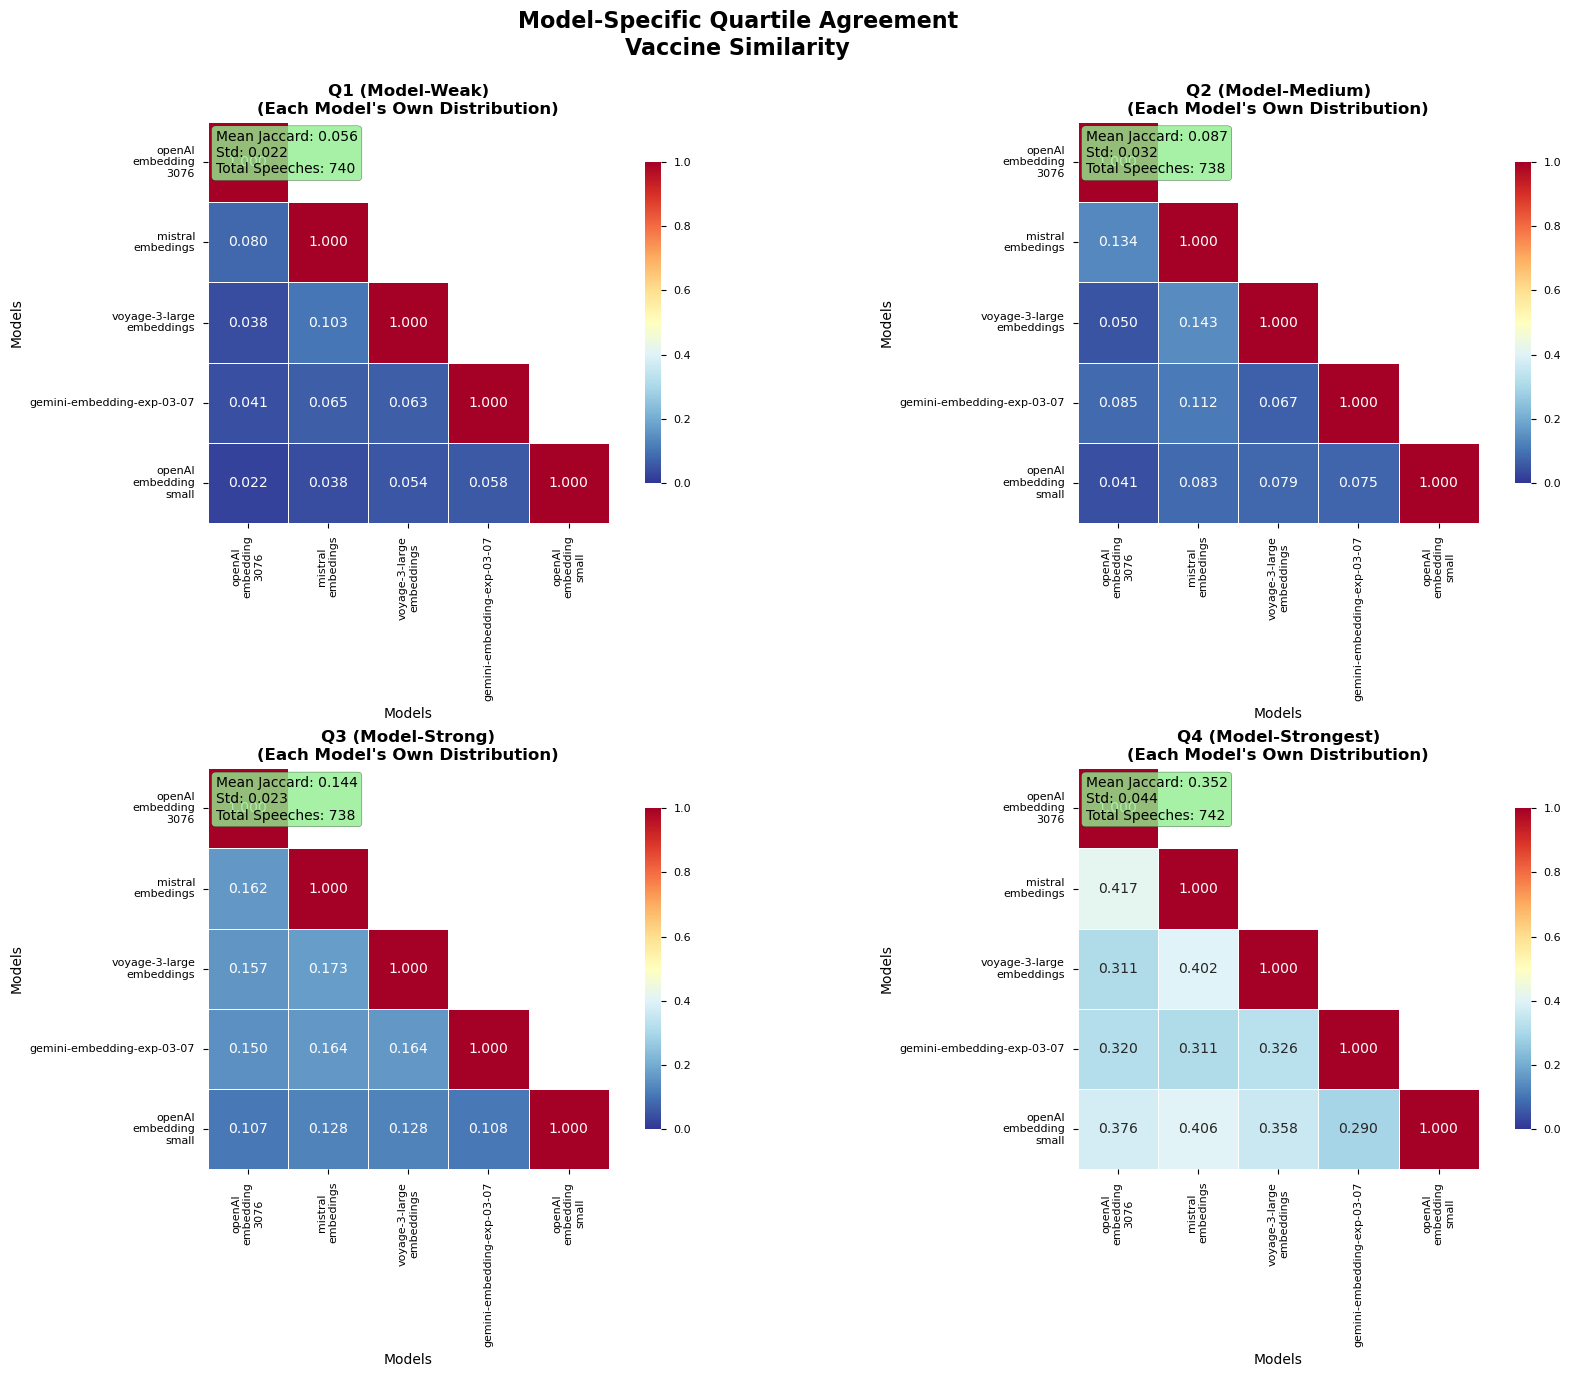


📈 MODEL-SPECIFIC QUARTILE ANALYSIS for Vaccine:
----------------------------------------------------------------------

🎯 MODEL-SPECIFIC QUARTILE RANGES:
  openAI_embedding_3076:
    Q1: 0.477 - 0.492 (91 speeches)
    Q2: 0.492 - 0.512 (91 speeches)
    Q3: 0.512 - 0.533 (91 speeches)
    Q4: 0.533 - 0.626 (92 speeches)
  mistral_embedings:
    Q1: 0.868 - 0.875 (139 speeches)
    Q2: 0.875 - 0.884 (138 speeches)
    Q3: 0.884 - 0.895 (138 speeches)
    Q4: 0.895 - 0.923 (139 speeches)
  voyage-3-large_embeddings:
    Q1: 0.626 - 0.643 (181 speeches)
    Q2: 0.643 - 0.666 (181 speeches)
    Q3: 0.666 - 0.693 (181 speeches)
    Q4: 0.693 - 0.765 (182 speeches)
  gemini-embedding-exp-03-07:
    Q1: 0.722 - 0.733 (139 speeches)
    Q2: 0.733 - 0.746 (139 speeches)
    Q3: 0.746 - 0.763 (139 speeches)
    Q4: 0.763 - 0.814 (139 speeches)
  openAI_embedding_small:
    Q1: 0.439 - 0.455 (190 speeches)
    Q2: 0.455 - 0.483 (189 speeches)
    Q3: 0.483 - 0.523 (189 speeches)
    Q4: 0.523 -

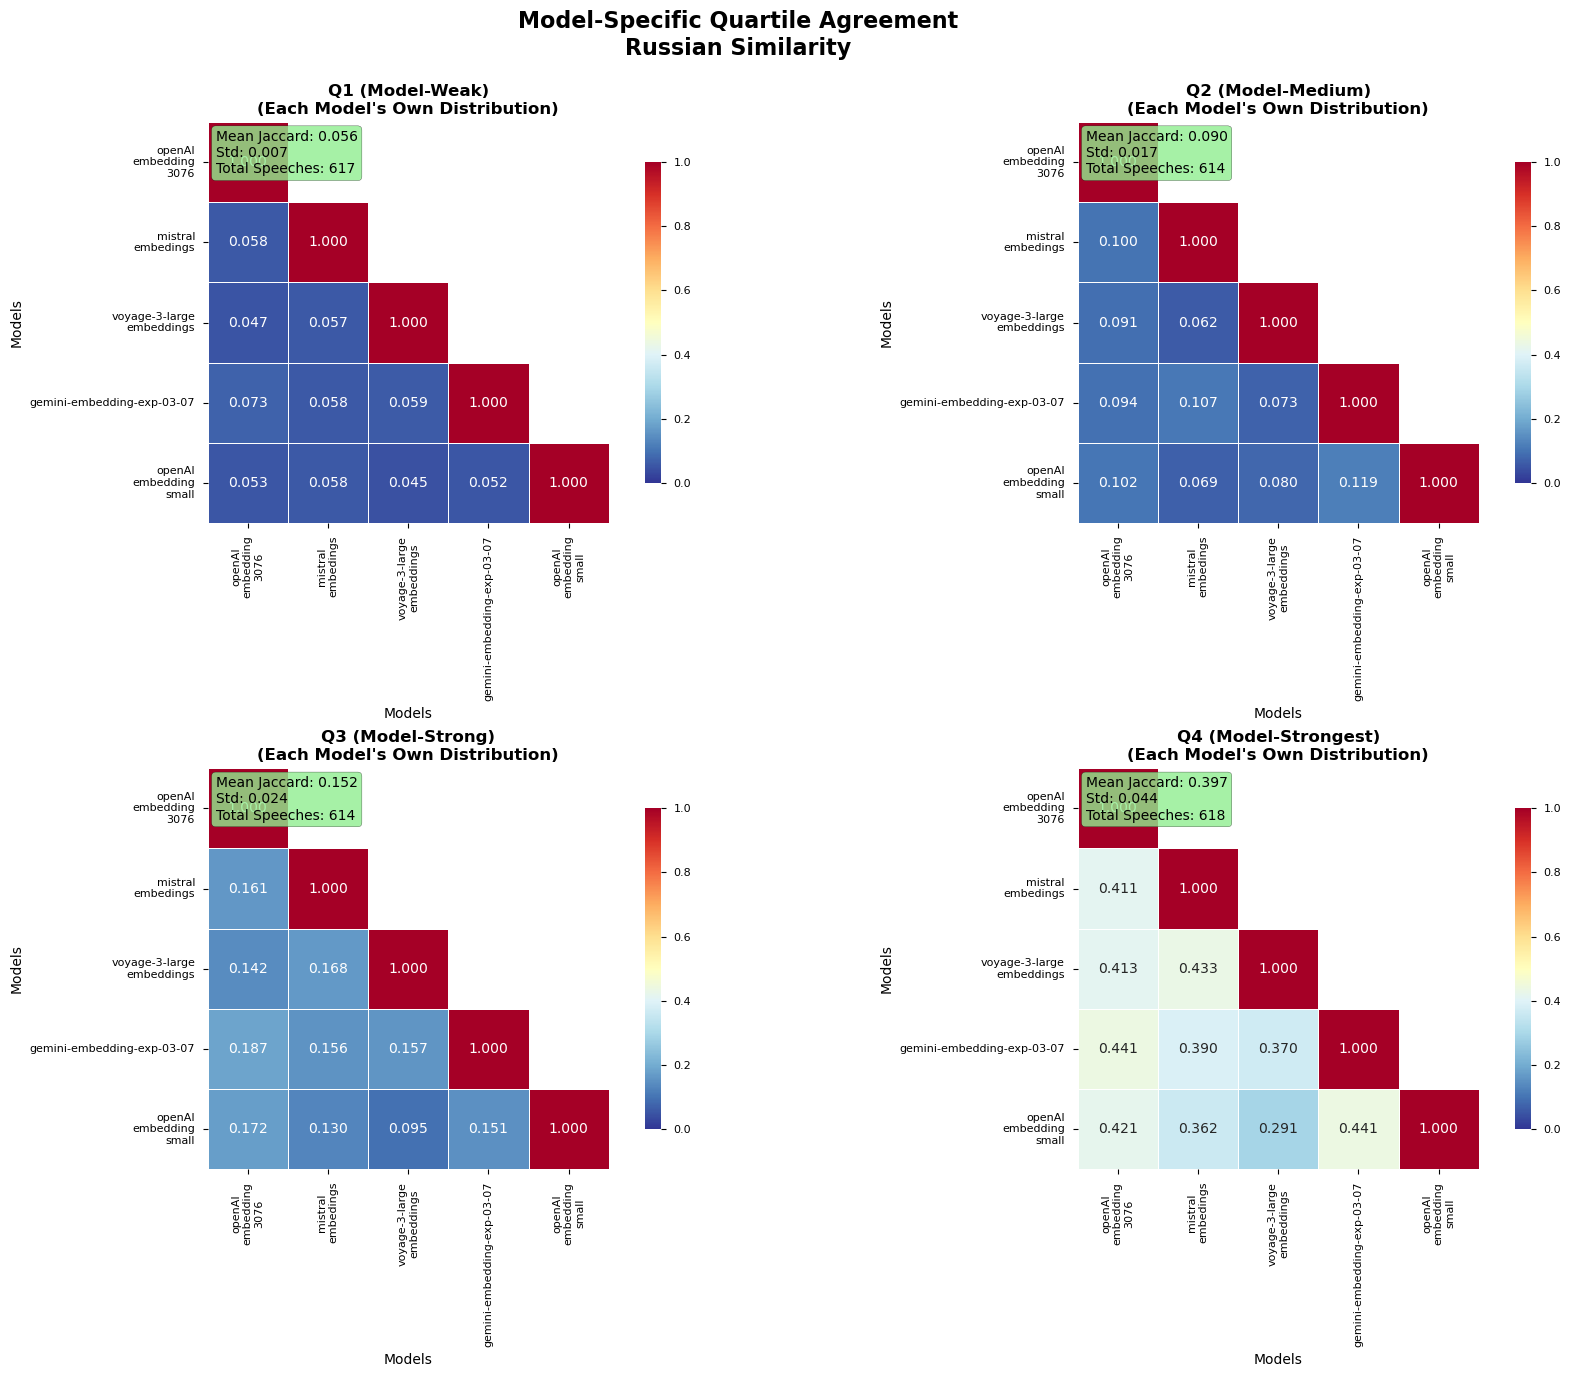


📈 MODEL-SPECIFIC QUARTILE ANALYSIS for Russian:
----------------------------------------------------------------------

🎯 MODEL-SPECIFIC QUARTILE RANGES:
  openAI_embedding_3076:
    Q1: 0.419 - 0.438 (148 speeches)
    Q2: 0.438 - 0.467 (147 speeches)
    Q3: 0.467 - 0.513 (147 speeches)
    Q4: 0.513 - 0.648 (148 speeches)
  mistral_embedings:
    Q1: 0.865 - 0.869 (106 speeches)
    Q2: 0.869 - 0.875 (105 speeches)
    Q3: 0.875 - 0.886 (105 speeches)
    Q4: 0.886 - 0.919 (106 speeches)
  voyage-3-large_embeddings:
    Q1: 0.646 - 0.657 (118 speeches)
    Q2: 0.657 - 0.675 (118 speeches)
    Q3: 0.675 - 0.699 (118 speeches)
    Q4: 0.699 - 0.795 (119 speeches)
  gemini-embedding-exp-03-07:
    Q1: 0.696 - 0.707 (133 speeches)
    Q2: 0.707 - 0.720 (132 speeches)
    Q3: 0.720 - 0.744 (132 speeches)
    Q4: 0.744 - 0.803 (133 speeches)
  openAI_embedding_small:
    Q1: 0.501 - 0.518 (112 speeches)
    Q2: 0.518 - 0.543 (112 speeches)
    Q3: 0.543 - 0.574 (112 speeches)
    Q4: 0.5

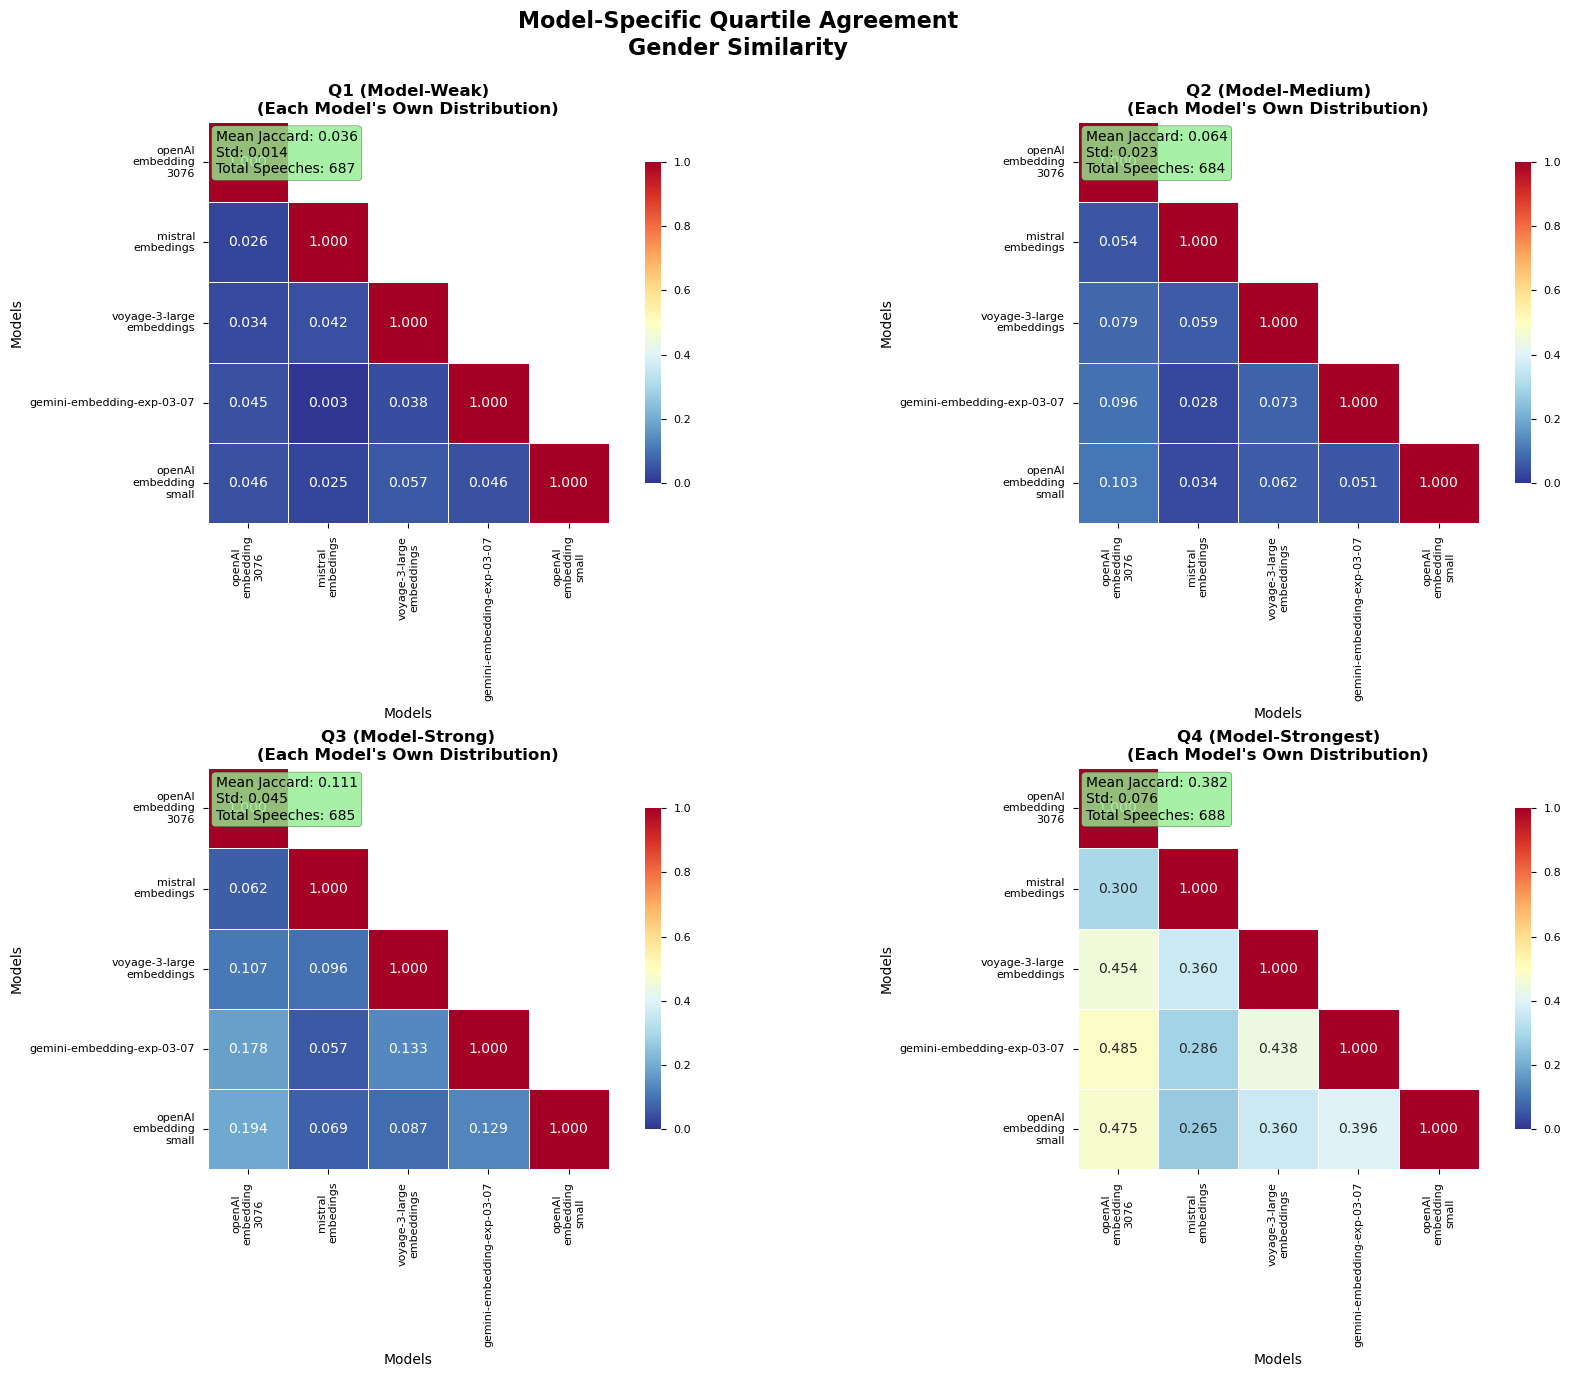


📈 MODEL-SPECIFIC QUARTILE ANALYSIS for Gender:
----------------------------------------------------------------------

🎯 MODEL-SPECIFIC QUARTILE RANGES:
  openAI_embedding_3076:
    Q1: 0.449 - 0.461 (114 speeches)
    Q2: 0.461 - 0.480 (114 speeches)
    Q3: 0.480 - 0.516 (114 speeches)
    Q4: 0.516 - 0.694 (115 speeches)
  mistral_embedings:
    Q1: 0.844 - 0.847 (158 speeches)
    Q2: 0.847 - 0.850 (157 speeches)
    Q3: 0.850 - 0.857 (158 speeches)
    Q4: 0.857 - 0.905 (158 speeches)
  voyage-3-large_embeddings:
    Q1: 0.630 - 0.641 (186 speeches)
    Q2: 0.641 - 0.656 (186 speeches)
    Q3: 0.656 - 0.683 (186 speeches)
    Q4: 0.683 - 0.819 (186 speeches)
  gemini-embedding-exp-03-07:
    Q1: 0.664 - 0.672 (139 speeches)
    Q2: 0.672 - 0.684 (138 speeches)
    Q3: 0.684 - 0.707 (138 speeches)
    Q4: 0.707 - 0.817 (139 speeches)
  openAI_embedding_small:
    Q1: 0.438 - 0.449 (90 speeches)
    Q2: 0.449 - 0.465 (89 speeches)
    Q3: 0.465 - 0.489 (89 speeches)
    Q4: 0.489 -

In [ ]:
# MODEL-SPECIFIC QUARTILE ANALYSIS: Each Model's Own Score Distribution
# Calculate quartiles separately for each model's above-threshold scores, then compare agreement

def jaccard_model_quartiles(set1, set2):
    """Calculate Jaccard similarity between two binary sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0

print("📊 MODEL-SPECIFIC QUARTILE ANALYSIS: Each Model's Own Score Distribution")
print("="*85)

# For each narrative, analyze model-specific quartiles
for narrative in ['vaccine_similarity', 'russian_similarity', 'gender_similarity']:
    print(f"\n=== {narrative.replace('_similarity', '').upper()} NARRATIVE - MODEL-SPECIFIC QUARTILES ===")
    
    # Get all PWLF threshold columns for this narrative
    pwlf_cols = [col for col in df.columns if f'_{narrative}_pwlf_above_threshold' in col]
    
    if len(pwlf_cols) < 2:
        print(f"Not enough models found for {narrative} (need at least 2)")
        continue
    
    # Get corresponding cosine score columns
    score_cols = []
    model_names = []
    for col in pwlf_cols:
        model_name = col.replace(f'_{narrative}_pwlf_above_threshold', '')
        score_col = f"{model_name}_{narrative}_cosine_score"
        
        if score_col in df.columns:
            score_cols.append(score_col)
            model_names.append(model_name)
    
    if len(score_cols) < 2:
        print(f"Not enough score columns found for {narrative}")
        continue
    
    print(f"Analyzing {len(model_names)} models: {', '.join(model_names)}")
    
    # STEP 1: Calculate model-specific quartiles
    model_quartiles = {}
    model_above_threshold_data = {}
    
    for i, (model_name, score_col, pwlf_col) in enumerate(zip(model_names, score_cols, pwlf_cols)):
        # Get above-threshold data for this specific model
        model_above_thresh = df[df[pwlf_col] == 1].copy()
        
        if len(model_above_thresh) == 0:
            print(f"  {model_name}: No above-threshold speeches")
            continue
        
        # Get scores for above-threshold speeches only
        above_thresh_scores = model_above_thresh[score_col].dropna()
        
        if len(above_thresh_scores) == 0:
            print(f"  {model_name}: No valid scores")
            continue
        
        # Calculate quartiles for this model's above-threshold scores
        q25 = np.percentile(above_thresh_scores, 25)
        q50 = np.percentile(above_thresh_scores, 50)
        q75 = np.percentile(above_thresh_scores, 75)
        min_score = above_thresh_scores.min()
        max_score = above_thresh_scores.max()
        
        model_quartiles[model_name] = {
            'quartiles': [min_score, q25, q50, q75, max_score],
            'data': model_above_thresh,
            'scores': above_thresh_scores,
            'score_col': score_col,
            'pwlf_col': pwlf_col
        }
        
        print(f"  {model_name}: {len(model_above_thresh)} above-threshold speeches")
        print(f"    Score range: {min_score:.3f} - {max_score:.3f}")
        print(f"    Quartiles: Q1={q25:.3f}, Q2={q50:.3f}, Q3={q75:.3f}")
    
    if len(model_quartiles) < 2:
        print(f"Not enough models with above-threshold data for {narrative}")
        continue
    
    # STEP 2: Create comparison heatmaps across quartiles
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    quartile_labels = ['Q1 (Model-Weak)', 'Q2 (Model-Medium)', 'Q3 (Model-Strong)', 'Q4 (Model-Strongest)']
    
    for q_idx in range(4):
        ax = axes[q_idx]
        
        # Create Jaccard similarity matrix for this quartile
        active_models = list(model_quartiles.keys())
        n_models = len(active_models)
        jaccard_matrix = np.zeros((n_models, n_models))
        
        quartile_info = {}
        
        for i in range(n_models):
            for j in range(n_models):
                if i == j:
                    jaccard_matrix[i, j] = 1.0  # Perfect similarity with itself
                else:
                    model_i = active_models[i]
                    model_j = active_models[j]
                    
                    model_i_data = model_quartiles[model_i]
                    model_j_data = model_quartiles[model_j]
                    
                    # Get quartile ranges for each model
                    q_min_i = model_i_data['quartiles'][q_idx]
                    q_max_i = model_i_data['quartiles'][q_idx + 1]
                    
                    q_min_j = model_j_data['quartiles'][q_idx]
                    q_max_j = model_j_data['quartiles'][q_idx + 1]
                    
                    # Get speeches in this quartile for each model
                    if q_idx == 3:  # Last quartile, include upper bound
                        mask_i = (model_i_data['scores'] >= q_min_i) & (model_i_data['scores'] <= q_max_i)
                        mask_j = (model_j_data['scores'] >= q_min_j) & (model_j_data['scores'] <= q_max_j)
                    else:
                        mask_i = (model_i_data['scores'] >= q_min_i) & (model_i_data['scores'] < q_max_i)
                        mask_j = (model_j_data['scores'] >= q_min_j) & (model_j_data['scores'] < q_max_j)
                    
                    # Get speeches in this quartile for each model
                    quartile_speeches_i = model_i_data['data'][mask_i]
                    quartile_speeches_j = model_j_data['data'][mask_j]
                    
                    if len(quartile_speeches_i) == 0 or len(quartile_speeches_j) == 0:
                        jaccard_matrix[i, j] = 0.0
                        continue
                    
                    # Get indices of speeches in this quartile
                    set_i = set(quartile_speeches_i.index)
                    set_j = set(quartile_speeches_j.index)
                    
                    # Store quartile info for summary
                    if i not in quartile_info:
                        quartile_info[i] = {
                            'model': model_i,
                            'count': len(quartile_speeches_i),
                            'range': (q_min_i, q_max_i)
                        }
                    if j not in quartile_info:
                        quartile_info[j] = {
                            'model': model_j,
                            'count': len(quartile_speeches_j),
                            'range': (q_min_j, q_max_j)
                        }
                    
                    # Calculate Jaccard similarity
                    jaccard_matrix[i, j] = jaccard_model_quartiles(set_i, set_j)
        
        # Create DataFrame for heatmap
        display_names = [name.replace('_', '\n') for name in active_models]
        jaccard_df = pd.DataFrame(jaccard_matrix, 
                                 index=display_names, 
                                 columns=display_names)
        
        # Create heatmap (show lower triangle only)
        mask = np.triu(np.ones_like(jaccard_df), k=1)
        
        sns.heatmap(jaccard_df, 
                    annot=True, 
                    cmap='RdYlBu_r',
                    center=0.5,
                    square=True,
                    linewidths=0.5,
                    cbar_kws={"shrink": 0.8},
                    fmt='.3f',
                    mask=mask,
                    ax=ax,
                    vmin=0,
                    vmax=1)
        
        ax.set_title(f'{quartile_labels[q_idx]}\n(Each Model\'s Own Distribution)', 
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Models', fontsize=10)
        ax.set_ylabel('Models', fontsize=10)
        
        # Calculate summary stats for this quartile
        lower_triangle = jaccard_matrix[np.tril_indices_from(jaccard_matrix, k=-1)]
        if len(lower_triangle) > 0:
            mean_agreement = np.mean(lower_triangle)
            std_agreement = np.std(lower_triangle)
            
            # Count total speeches across models in this quartile
            total_speeches = sum([info['count'] for info in quartile_info.values()])
            
            # Add text box with stats
            textstr = f'Mean Jaccard: {mean_agreement:.3f}\nStd: {std_agreement:.3f}\nTotal Speeches: {total_speeches}'
            props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=props)
    
    plt.suptitle(f'Model-Specific Quartile Agreement\n{narrative.replace("_", " ").title()}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.savefig(f'../graphs/model_specific_quartiles_{narrative}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # STEP 3: Detailed analysis
    print(f"\n📈 MODEL-SPECIFIC QUARTILE ANALYSIS for {narrative.replace('_similarity', '').title()}:")
    print("-" * 70)
    
    # Show each model's quartile ranges
    print(f"\n🎯 MODEL-SPECIFIC QUARTILE RANGES:")
    for model_name, model_data in model_quartiles.items():
        quartiles = model_data['quartiles']
        print(f"  {model_name}:")
        for q_idx in range(4):
            q_min = quartiles[q_idx]
            q_max = quartiles[q_idx + 1]
            
            # Count speeches in this quartile
            if q_idx == 3:
                mask = (model_data['scores'] >= q_min) & (model_data['scores'] <= q_max)
            else:
                mask = (model_data['scores'] >= q_min) & (model_data['scores'] < q_max)
            
            count = mask.sum()
            print(f"    Q{q_idx+1}: {q_min:.3f} - {q_max:.3f} ({count} speeches)")
    
    # Cross-quartile agreement analysis
    print(f"\n🔍 CROSS-QUARTILE AGREEMENT PATTERNS:")
    
    active_models = list(model_quartiles.keys())
    
    for q_idx in range(4):
        print(f"\n  {quartile_labels[q_idx]}:")
        
        quartile_agreements = []
        
        for i in range(len(active_models)):
            for j in range(i+1, len(active_models)):
                model_i = active_models[i]
                model_j = active_models[j]
                
                model_i_data = model_quartiles[model_i]
                model_j_data = model_quartiles[model_j]
                
                # Get quartile ranges
                q_min_i = model_i_data['quartiles'][q_idx]
                q_max_i = model_i_data['quartiles'][q_idx + 1]
                q_min_j = model_j_data['quartiles'][q_idx]
                q_max_j = model_j_data['quartiles'][q_idx + 1]
                
                # Get speeches in this quartile for each model
                if q_idx == 3:
                    mask_i = (model_i_data['scores'] >= q_min_i) & (model_i_data['scores'] <= q_max_i)
                    mask_j = (model_j_data['scores'] >= q_min_j) & (model_j_data['scores'] <= q_max_j)
                else:
                    mask_i = (model_i_data['scores'] >= q_min_i) & (model_i_data['scores'] < q_max_i)
                    mask_j = (model_j_data['scores'] >= q_min_j) & (model_j_data['scores'] < q_max_j)
                
                quartile_speeches_i = model_i_data['data'][mask_i]
                quartile_speeches_j = model_j_data['data'][mask_j]
                
                if len(quartile_speeches_i) > 0 and len(quartile_speeches_j) > 0:
                    set_i = set(quartile_speeches_i.index)
                    set_j = set(quartile_speeches_j.index)
                    
                    jaccard_val = jaccard_model_quartiles(set_i, set_j)
                    quartile_agreements.append(jaccard_val)
                    
                    print(f"    {model_i} ↔ {model_j}: Jaccard = {jaccard_val:.3f}")
                    print(f"      {model_i}: {len(quartile_speeches_i)} speeches ({q_min_i:.3f}-{q_max_i:.3f})")
                    print(f"      {model_j}: {len(quartile_speeches_j)} speeches ({q_min_j:.3f}-{q_max_j:.3f})")
        
        if quartile_agreements:
            mean_agreement = np.mean(quartile_agreements)
            print(f"    → Average Jaccard for {quartile_labels[q_idx]}: {mean_agreement:.3f}")
            
            if mean_agreement > 0.6:
                print(f"    → HIGH agreement: Models agree well in their respective {quartile_labels[q_idx].lower()}")
            elif mean_agreement > 0.3:
                print(f"    → MODERATE agreement: Some alignment in {quartile_labels[q_idx].lower()}")
            else:
                print(f"    → LOW agreement: Different patterns in {quartile_labels[q_idx].lower()}")
    
    # Summary insights
    print(f"\n💡 KEY INSIGHTS for {narrative.replace('_similarity', '').title()}:")
    print("-" * 70)
    
    # Calculate agreement progression across quartiles
    quartile_means = []
    for q_idx in range(4):
        q_agreements = []
        for i in range(len(active_models)):
            for j in range(i+1, len(active_models)):
                model_i = active_models[i]
                model_j = active_models[j]
                
                model_i_data = model_quartiles[model_i]
                model_j_data = model_quartiles[model_j]
                
                q_min_i = model_i_data['quartiles'][q_idx]
                q_max_i = model_i_data['quartiles'][q_idx + 1]
                q_min_j = model_j_data['quartiles'][q_idx]
                q_max_j = model_j_data['quartiles'][q_idx + 1]
                
                if q_idx == 3:
                    mask_i = (model_i_data['scores'] >= q_min_i) & (model_i_data['scores'] <= q_max_i)
                    mask_j = (model_j_data['scores'] >= q_min_j) & (model_j_data['scores'] <= q_max_j)
                else:
                    mask_i = (model_i_data['scores'] >= q_min_i) & (model_i_data['scores'] < q_max_i)
                    mask_j = (model_j_data['scores'] >= q_min_j) & (model_j_data['scores'] < q_max_j)
                
                quartile_speeches_i = model_i_data['data'][mask_i]
                quartile_speeches_j = model_j_data['data'][mask_j]
                
                if len(quartile_speeches_i) > 0 and len(quartile_speeches_j) > 0:
                    set_i = set(quartile_speeches_i.index)
                    set_j = set(quartile_speeches_j.index)
                    jaccard_val = jaccard_model_quartiles(set_i, set_j)
                    q_agreements.append(jaccard_val)
        
        if q_agreements:
            quartile_means.append(np.mean(q_agreements))
    
    if len(quartile_means) >= 4:
        print(f"  Agreement progression: Q1={quartile_means[0]:.3f} → Q2={quartile_means[1]:.3f} → Q3={quartile_means[2]:.3f} → Q4={quartile_means[3]:.3f}")
        
        if quartile_means[3] > quartile_means[0]:
            print(f"  → Agreement INCREASES from weak to strong model predictions")
        elif quartile_means[3] < quartile_means[0]:
            print(f"  → Agreement DECREASES from weak to strong model predictions")
        else:
            print(f"  → Agreement remains STABLE across model prediction strengths")
        
        # Find best and worst quartiles
        best_q = np.argmax(quartile_means) + 1
        worst_q = np.argmin(quartile_means) + 1
        print(f"  → Best agreement in Q{best_q} ({quartile_means[best_q-1]:.3f})")
        print(f"  → Worst agreement in Q{worst_q} ({quartile_means[worst_q-1]:.3f})")
    
    # Model distribution comparison
    print(f"\n📊 MODEL DISTRIBUTION COMPARISON:")
    for model_name, model_data in model_quartiles.items():
        quartiles = model_data['quartiles']
        range_span = quartiles[4] - quartiles[0]  # max - min
        iqr = quartiles[3] - quartiles[1]  # Q3 - Q1
        print(f"  {model_name}: Range span = {range_span:.3f}, IQR = {iqr:.3f}")
        print(f"    → {'Wide' if range_span > 0.2 else 'Narrow'} distribution, {'High' if iqr > 0.1 else 'Low'} variability")

print(f"\n" + "="*85)
print("INTERPRETATION GUIDE - MODEL-SPECIFIC QUARTILES:")
print("• Each model's quartiles calculated from its own above-threshold score distribution")
print("• Q1 = Each model's weakest positive predictions (bottom 25% of its positives)")
print("• Q4 = Each model's strongest positive predictions (top 25% of its positives)")
print("• High Jaccard = Models agree on similar speeches within their respective quartiles")
print("• This accounts for different score distributions across embedding models")
print("• Expected: Better agreement in Q4 (each model's strongest) vs Q1 (each model's weakest)")
print("="*85)

In [ ]:
# UNIQUENESS OVERLAP ANALYSIS: How many models share each "unique" positive prediction
# For each model's positive predictions, analyze how many other models also marked them as positive

print("📊 UNIQUENESS OVERLAP ANALYSIS: Sharing of Positive Predictions Across Models")
print("="*85)

def analyze_uniqueness_overlap(narrative):
    """Analyze how many models share each positive prediction for a given narrative"""
    
    # Get all PWLF threshold columns for this narrative
    pwlf_cols = [col for col in df.columns if f'_{narrative}_pwlf_above_threshold' in col]
    
    if len(pwlf_cols) < 2:
        print(f"Not enough models found for {narrative} (need at least 2)")
        return None
    
    # Get model names
    model_names = []
    for col in pwlf_cols:
        model_name = col.replace(f'_{narrative}_pwlf_above_threshold', '')
        model_names.append(model_name)
    
    print(f"Analyzing {len(model_names)} models: {', '.join(model_names)}")
    
    # For each model, analyze its positive predictions
    model_overlap_data = {}
    
    for model_name in model_names:
        pwlf_col = f"{model_name}_{narrative}_pwlf_above_threshold"
        
        # Get speeches marked as positive by this model
        model_positives = df[df[pwlf_col] == 1].copy()
        
        if len(model_positives) == 0:
            model_overlap_data[model_name] = {f'{i}_models': 0 for i in range(1, len(model_names) + 1)}
            continue
        
        # For each positive speech, count how many models marked it as positive
        overlap_counts = {f'{i}_models': 0 for i in range(1, len(model_names) + 1)}
        
        for idx in model_positives.index:
            # Count how many models marked this speech as positive
            total_models_positive = 0
            for other_model in model_names:
                other_pwlf_col = f"{other_model}_{narrative}_pwlf_above_threshold"
                if df.loc[idx, other_pwlf_col] == 1:
                    total_models_positive += 1
            
            # Categorize by number of models that marked it positive
            if total_models_positive <= len(model_names):
                overlap_counts[f'{total_models_positive}_models'] += 1
        
        model_overlap_data[model_name] = overlap_counts
        
        # Print summary for this model
        total_positives = sum(overlap_counts.values())
        print(f"\n  {model_name}: {total_positives} positive predictions")
        for models_count, speech_count in overlap_counts.items():
            if speech_count > 0:
                percentage = (speech_count / total_positives) * 100 if total_positives > 0 else 0
                print(f"    {models_count}: {speech_count} speeches ({percentage:.1f}%)")
    
    return model_overlap_data, model_names

# Analyze each narrative
narratives = ['vaccine_similarity', 'russian_similarity', 'gender_similarity']
all_narrative_data = {}

for narrative in narratives:
    print(f"\n{'='*60}")
    print(f"NARRATIVE: {narrative.replace('_similarity', '').upper()}")
    print(f"{'='*60}")
    
    overlap_data, model_names = analyze_uniqueness_overlap(narrative)
    if overlap_data is not None:
        all_narrative_data[narrative] = {
            'overlap_data': overlap_data,
            'model_names': model_names
        }

print(f"\n" + "="*85)
print("CREATING VISUALIZATION...")
print("="*85)

📊 UNIQUENESS OVERLAP ANALYSIS: Sharing of Positive Predictions Across Models

NARRATIVE: VACCINE
Analyzing 5 models: openAI_embedding_3076, mistral_embedings, voyage-3-large_embeddings, gemini-embedding-exp-03-07, openAI_embedding_small

  openAI_embedding_3076: 365 positive predictions
    1_models: 2 speeches (0.5%)
    2_models: 8 speeches (2.2%)
    3_models: 22 speeches (6.0%)
    4_models: 81 speeches (22.2%)
    5_models: 252 speeches (69.0%)

  mistral_embedings: 554 positive predictions
    1_models: 28 speeches (5.1%)
    2_models: 61 speeches (11.0%)
    3_models: 74 speeches (13.4%)
    4_models: 139 speeches (25.1%)
    5_models: 252 speeches (45.5%)

  voyage-3-large_embeddings: 725 positive predictions
    1_models: 124 speeches (17.1%)
    2_models: 112 speeches (15.4%)
    3_models: 91 speeches (12.6%)
    4_models: 146 speeches (20.1%)
    5_models: 252 speeches (34.8%)

  gemini-embedding-exp-03-07: 556 positive predictions
    1_models: 55 speeches (9.9%)
    2_mode

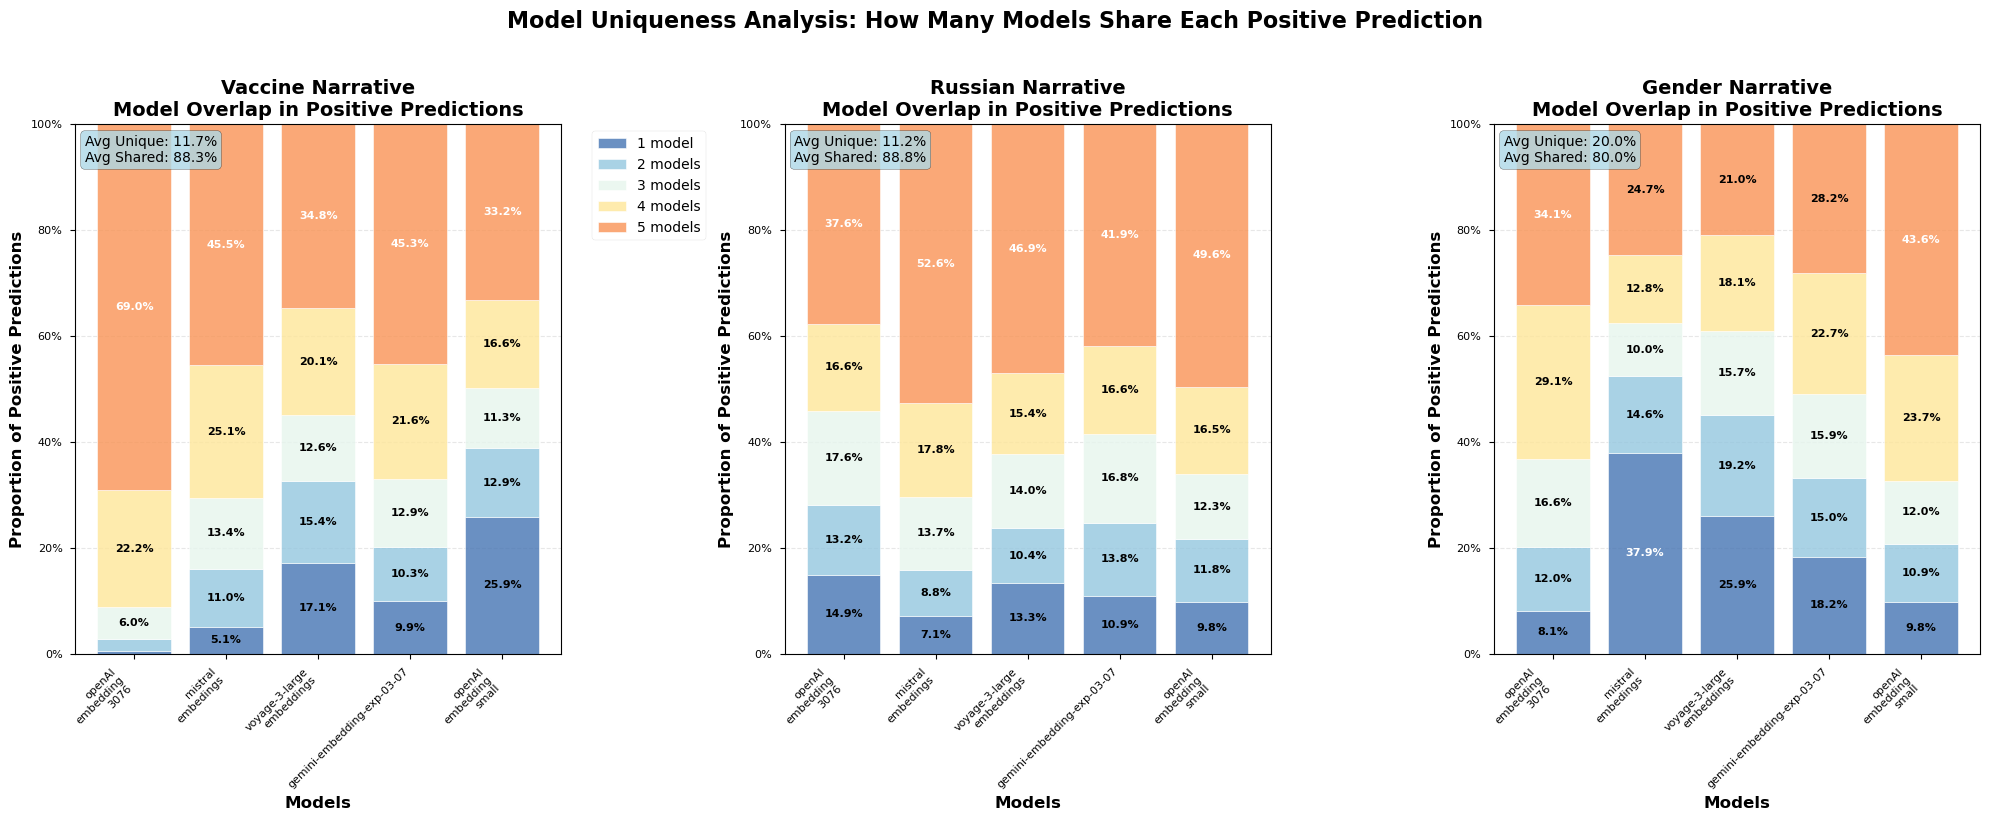


📈 UNIQUENESS OVERLAP SUMMARY:
----------------------------------------------------------------------

VACCINE NARRATIVE:
  openAI_embedding_3076:
    Total positives: 365
    Unique (1 model only): 2 (0.5%)
    Most common: 5 models agree (252 speeches, 69.0%)
    Average models agreeing: 4.6
  mistral_embedings:
    Total positives: 554
    Unique (1 model only): 28 (5.1%)
    Most common: 5 models agree (252 speeches, 45.5%)
    Average models agreeing: 3.9
  voyage-3-large_embeddings:
    Total positives: 725
    Unique (1 model only): 124 (17.1%)
    Most common: 5 models agree (252 speeches, 34.8%)
    Average models agreeing: 3.4
  gemini-embedding-exp-03-07:
    Total positives: 556
    Unique (1 model only): 55 (9.9%)
    Most common: 5 models agree (252 speeches, 45.3%)
    Average models agreeing: 3.8
  openAI_embedding_small:
    Total positives: 758
    Unique (1 model only): 196 (25.9%)
    Most common: 5 models agree (252 speeches, 33.2%)
    Average models agreeing: 3.2

In [ ]:
# CREATE STACKED BAR CHART: Proportion of Uniqueness for Each Model

if all_narrative_data:
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    
    # Color palette for different overlap levels
    colors = plt.cm.RdYlBu_r(np.linspace(0.1, 0.9, 6))  # Adjust number based on max models
    
    for i, (narrative, data) in enumerate(all_narrative_data.items()):
        ax = axes[i]
        overlap_data = data['overlap_data']
        model_names = data['model_names']
        
        # Prepare data for stacked bar chart
        models = list(overlap_data.keys())
        n_models_total = len(model_names)
        
        # Create matrix for stacked bars (proportions)
        overlap_categories = [f'{j}_models' for j in range(1, n_models_total + 1)]
        proportions_matrix = []
        
        for model in models:
            model_data = overlap_data[model]
            total_positives = sum(model_data.values())
            
            if total_positives > 0:
                proportions = [model_data[cat] / total_positives for cat in overlap_categories]
            else:
                proportions = [0] * len(overlap_categories)
            
            proportions_matrix.append(proportions)
        
        # Convert to numpy array for easier manipulation
        proportions_matrix = np.array(proportions_matrix)
        
        # Create stacked bar chart
        x_pos = np.arange(len(models))
        bar_width = 0.8
        
        bottom = np.zeros(len(models))
        
        for j, category in enumerate(overlap_categories):
            if j < len(colors):
                color = colors[j]
            else:
                color = plt.cm.Set3(j / len(overlap_categories))
            
            values = proportions_matrix[:, j]
            
            # Only plot if there are non-zero values
            if np.any(values > 0):
                bars = ax.bar(x_pos, values, bar_width, bottom=bottom, 
                             color=color, label=f'{j+1} model{"s" if j > 0 else ""}',
                             alpha=0.8, edgecolor='white', linewidth=0.5)
                
                # Add percentage labels for significant segments
                for k, (bar, value) in enumerate(zip(bars, values)):
                    if value > 0.05:  # Only label if > 5%
                        height = bar.get_height()
                        if height > 0.02:  # Only if bar is tall enough
                            ax.text(bar.get_x() + bar.get_width()/2., 
                                   bottom[k] + height/2.,
                                   f'{value:.1%}', 
                                   ha='center', va='center', 
                                   fontsize=8, fontweight='bold',
                                   color='white' if value > 0.3 else 'black')
                
                bottom += values
        
        # Customize the plot
        ax.set_xlabel('Models', fontsize=12, fontweight='bold')
        ax.set_ylabel('Proportion of Positive Predictions', fontsize=12, fontweight='bold')
        ax.set_title(f'{narrative.replace("_similarity", "").title()} Narrative\nModel Overlap in Positive Predictions', 
                     fontsize=14, fontweight='bold')
        
        # Set x-axis labels
        model_labels = [name.replace('_', '\n') for name in models]
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_labels, rotation=45, ha='right')
        
        # Add legend (only for first subplot)
        if i == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        
        # Set y-axis to percentage
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Add grid for better readability
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        # Add statistics text box
        # Calculate average uniqueness (1 model only)
        avg_unique = np.mean([proportions_matrix[k, 0] for k in range(len(models))])
        avg_shared = 1 - avg_unique
        
        textstr = f'Avg Unique: {avg_unique:.1%}\nAvg Shared: {avg_shared:.1%}'
        props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
               verticalalignment='top', bbox=props)
    
    plt.suptitle('Model Uniqueness Analysis: How Many Models Share Each Positive Prediction', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../graphs/model_uniqueness_overlap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # SUMMARY STATISTICS
    print(f"\n📈 UNIQUENESS OVERLAP SUMMARY:")
    print("-" * 70)
    
    for narrative, data in all_narrative_data.items():
        print(f"\n{narrative.replace('_similarity', '').upper()} NARRATIVE:")
        overlap_data = data['overlap_data']
        model_names = data['model_names']
        
        total_models = len(model_names)
        
        for model_name, model_data in overlap_data.items():
            total_positives = sum(model_data.values())
            if total_positives > 0:
                unique_count = model_data.get('1_models', 0)
                unique_pct = (unique_count / total_positives) * 100
                
                # Find most common overlap level
                max_overlap_category = max(model_data.items(), key=lambda x: x[1])
                max_overlap_models = int(max_overlap_category[0].split('_')[0])
                max_overlap_count = max_overlap_category[1]
                max_overlap_pct = (max_overlap_count / total_positives) * 100
                
                print(f"  {model_name}:")
                print(f"    Total positives: {total_positives}")
                print(f"    Unique (1 model only): {unique_count} ({unique_pct:.1f}%)")
                print(f"    Most common: {max_overlap_models} models agree ({max_overlap_count} speeches, {max_overlap_pct:.1f}%)")
                
                # Calculate average overlap
                weighted_avg = sum(int(k.split('_')[0]) * v for k, v in model_data.items()) / total_positives
                print(f"    Average models agreeing: {weighted_avg:.1f}")
    
    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 70)
    print("• Higher 'Unique' (1 model) = Model finds speeches others miss")
    print("• Higher 'Shared' (multiple models) = Strong consensus on narratives")
    print("• Different patterns across narratives suggest varying detection difficulty")
    print("• Models with high uniqueness may have distinct capabilities")

else:
    print("No data available for visualization.")

Kedže texty označené ako 1 budú podklad pre testovanie LLM, aby sme úžili vzorku a zvýšili istotu kontiminacie narrativom pouzijeme len texty, ktore su spolocne pre 4/5 modelov. 

In [ ]:
# CREATE UNIQUES COLUMNS: Count how many models labeled each text as positive (1) for each narrative
print("🔢 CREATING UNIQUES COLUMNS: Counting Model Agreement per Text")
print("="*75)

narratives = ['vaccine_similarity', 'russian_similarity', 'gender_similarity']

for narrative in narratives:
    print(f"\nProcessing {narrative.replace('_similarity', '').upper()} narrative...")
    
    # Get all PWLF threshold columns for this narrative
    pwlf_cols = [col for col in df.columns if f'_{narrative}_pwlf_above_threshold' in col]
    
    if len(pwlf_cols) == 0:
        print(f"  No PWLF threshold columns found for {narrative}")
        continue
    
    # Get model names for this narrative
    model_names = []
    for col in pwlf_cols:
        model_name = col.replace(f'_{narrative}_pwlf_above_threshold', '')
        model_names.append(model_name)
    
    print(f"  Found {len(model_names)} models: {', '.join(model_names)}")
    
    # Create the uniques column name
    uniques_col = f"{narrative.replace('_similarity', '')}_uniques"
    
    # Initialize the column with zeros
    df[uniques_col] = 0
    
    # For each row, count how many models labeled it as positive (1)
    for idx in df.index:
        count = 0
        for pwlf_col in pwlf_cols:
            if pd.notna(df.loc[idx, pwlf_col]) and df.loc[idx, pwlf_col] == 1:
                count += 1
        df.loc[idx, uniques_col] = count
    
    # Display statistics for this narrative
    value_counts = df[uniques_col].value_counts().sort_index()
    print(f"  Created column: {uniques_col}")
    print(f"  Distribution of agreement counts:")
    for agreement_count, num_texts in value_counts.items():
        percentage = (num_texts / len(df)) * 100
        print(f"    {agreement_count} models agree: {num_texts:,} texts ({percentage:.1f}%)")

print(f"\n" + "="*75)
print("📊 SUMMARY OF NEW UNIQUES COLUMNS:")
print("="*75)

# Display summary statistics for all uniques columns
uniques_columns = [col for col in df.columns if col.endswith('_uniques')]

for col in uniques_columns:
    narrative_name = col.replace('_uniques', '').upper()
    print(f"\n{narrative_name} NARRATIVE ({col}):")
    
    # Basic statistics
    total_texts = len(df)
    max_models = df[col].max()
    mean_agreement = df[col].mean()
    
    print(f"  Total texts: {total_texts:,}")
    print(f"  Max models available: {max_models}")
    print(f"  Average models agreeing: {mean_agreement:.2f}")
    
    # Distribution
    print(f"  Agreement distribution:")
    value_counts = df[col].value_counts().sort_index()
    for agreement_count, num_texts in value_counts.items():
        percentage = (num_texts / total_texts) * 100
        print(f"    {agreement_count} models: {num_texts:,} texts ({percentage:.1f}%)")

# Display first few rows to show the new columns
print(f"\n" + "="*75)
print("📋 SAMPLE DATA WITH NEW UNIQUES COLUMNS:")
print("="*75)

# Show relevant columns
display_cols = ['prepis'] + uniques_columns
if len(display_cols) > 1:
    sample_data = df[display_cols].head(10)
    print(sample_data.to_string(max_colwidth=50))

print(f"\n✅ Successfully created {len(uniques_columns)} uniques columns:")
for col in uniques_columns:
    print(f"   • {col}")

print(f"\nThese columns contain values from 0 to {df[uniques_columns].max().max()} indicating")
print("how many models agreed on labeling each text as positive for that narrative.")

🔢 CREATING UNIQUES COLUMNS: Counting Model Agreement per Text

Processing VACCINE narrative...
  Found 5 models: openAI_embedding_3076, mistral_embedings, voyage-3-large_embeddings, gemini-embedding-exp-03-07, openAI_embedding_small
  Created column: vaccine_uniques
  Distribution of agreement counts:
    0 models agree: 18,821 texts (94.4%)
    1 models agree: 426 texts (2.1%)
    2 models agree: 160 texts (0.8%)
    3 models agree: 117 texts (0.6%)
    4 models agree: 144 texts (0.7%)
    5 models agree: 259 texts (1.3%)

Processing RUSSIAN narrative...
  Found 5 models: openAI_embedding_3076, mistral_embedings, voyage-3-large_embeddings, gemini-embedding-exp-03-07, openAI_embedding_small
  Created column: vaccine_uniques
  Distribution of agreement counts:
    0 models agree: 18,821 texts (94.4%)
    1 models agree: 426 texts (2.1%)
    2 models agree: 160 texts (0.8%)
    3 models agree: 117 texts (0.6%)
    4 models agree: 144 texts (0.7%)
    5 models agree: 259 texts (1.3%)

Pro

In [ ]:
df.to_parquet(r"..\data\df_to_app_with_openAI_S_L_voyage_gdoogle_mistral_embeddings_obdobie_8_narrative_elbow_updated.parquet", engine="fastparquet")